In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [88]:
# mel data
mel_1_l = pd.read_csv('../pipeline/zonetab-mel-animal-1-l/data.csv')
mel_1_r = pd.read_csv('../pipeline/zonetab-mel-animal-1-r/data.csv')
mel_2_l = pd.read_csv('../pipeline/zonetab-mel-animal-2-l/data.csv')
mel_2_r = pd.read_csv('../pipeline/zonetab-mel-animal-2-r/data.csv')
mel_3_l = pd.read_csv('../pipeline/zonetab-mel-animal-3-l/data.csv')
mel_3_r = pd.read_csv('../pipeline/zonetab-mel-animal-3-r/data.csv')

# sim data
sim_1_l = pd.read_csv('../pipeline/zonetab-sim-animal-2-l/data.csv')
sim_1_r = pd.read_csv('../pipeline/zonetab-sim-animal-2-r/data.csv')
sim_2_l = pd.read_csv('../pipeline/zonetab-sim-animal-3-l/data.csv')
sim_2_r = pd.read_csv('../pipeline/zonetab-sim-animal-3-r/data.csv')
sim_3_l = pd.read_csv('../pipeline/zonetab-sim-animal-4-l/data.csv')
sim_3_r = pd.read_csv('../pipeline/zonetab-sim-animal-4-r/data.csv')

# only metric data saved
data = dict(mel_1_l=mel_1_l.iloc[:, [1, 2, 3]].to_numpy(),
            mel_1_r=mel_1_r.iloc[:, [1, 2, 3]].to_numpy(),
            mel_2_l=mel_2_l.iloc[:, [1, 2, 3]].to_numpy(),
            mel_2_r=mel_2_r.iloc[:, [1, 2, 3]].to_numpy(),
            mel_3_l=mel_3_l.iloc[:, [1, 2, 3]].to_numpy(),
            mel_3_r=mel_3_r.iloc[:, [1, 2, 3]].to_numpy(),
            sim_2_l=sim_1_l.iloc[:, [1, 2, 3]].to_numpy(),
            sim_2_r=sim_1_r.iloc[:, [1, 2, 3]].to_numpy(),
            sim_3_l=sim_2_l.iloc[:, [1, 2, 3]].to_numpy(),
            sim_3_r=sim_2_r.iloc[:, [1, 2, 3]].to_numpy(),
            sim_4_l=sim_3_l.iloc[:, [1, 2, 3]].to_numpy(),
            sim_4_r=sim_3_r.iloc[:, [1, 2, 3]].to_numpy())

In [89]:
def draw(data, labels, title, name):
    plt.close('all')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=90, azim=90)
    ax.scatter(data[:, 0],
               data[:, 1],
               data[:, 2],
               c=labels)
    ax.set_title(title)
    plt.savefig(name)
    plt.show()

# k-means

In [90]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=14, 
                random_state=21, 
                init='k-means++')

<IPython.core.display.Javascript object>


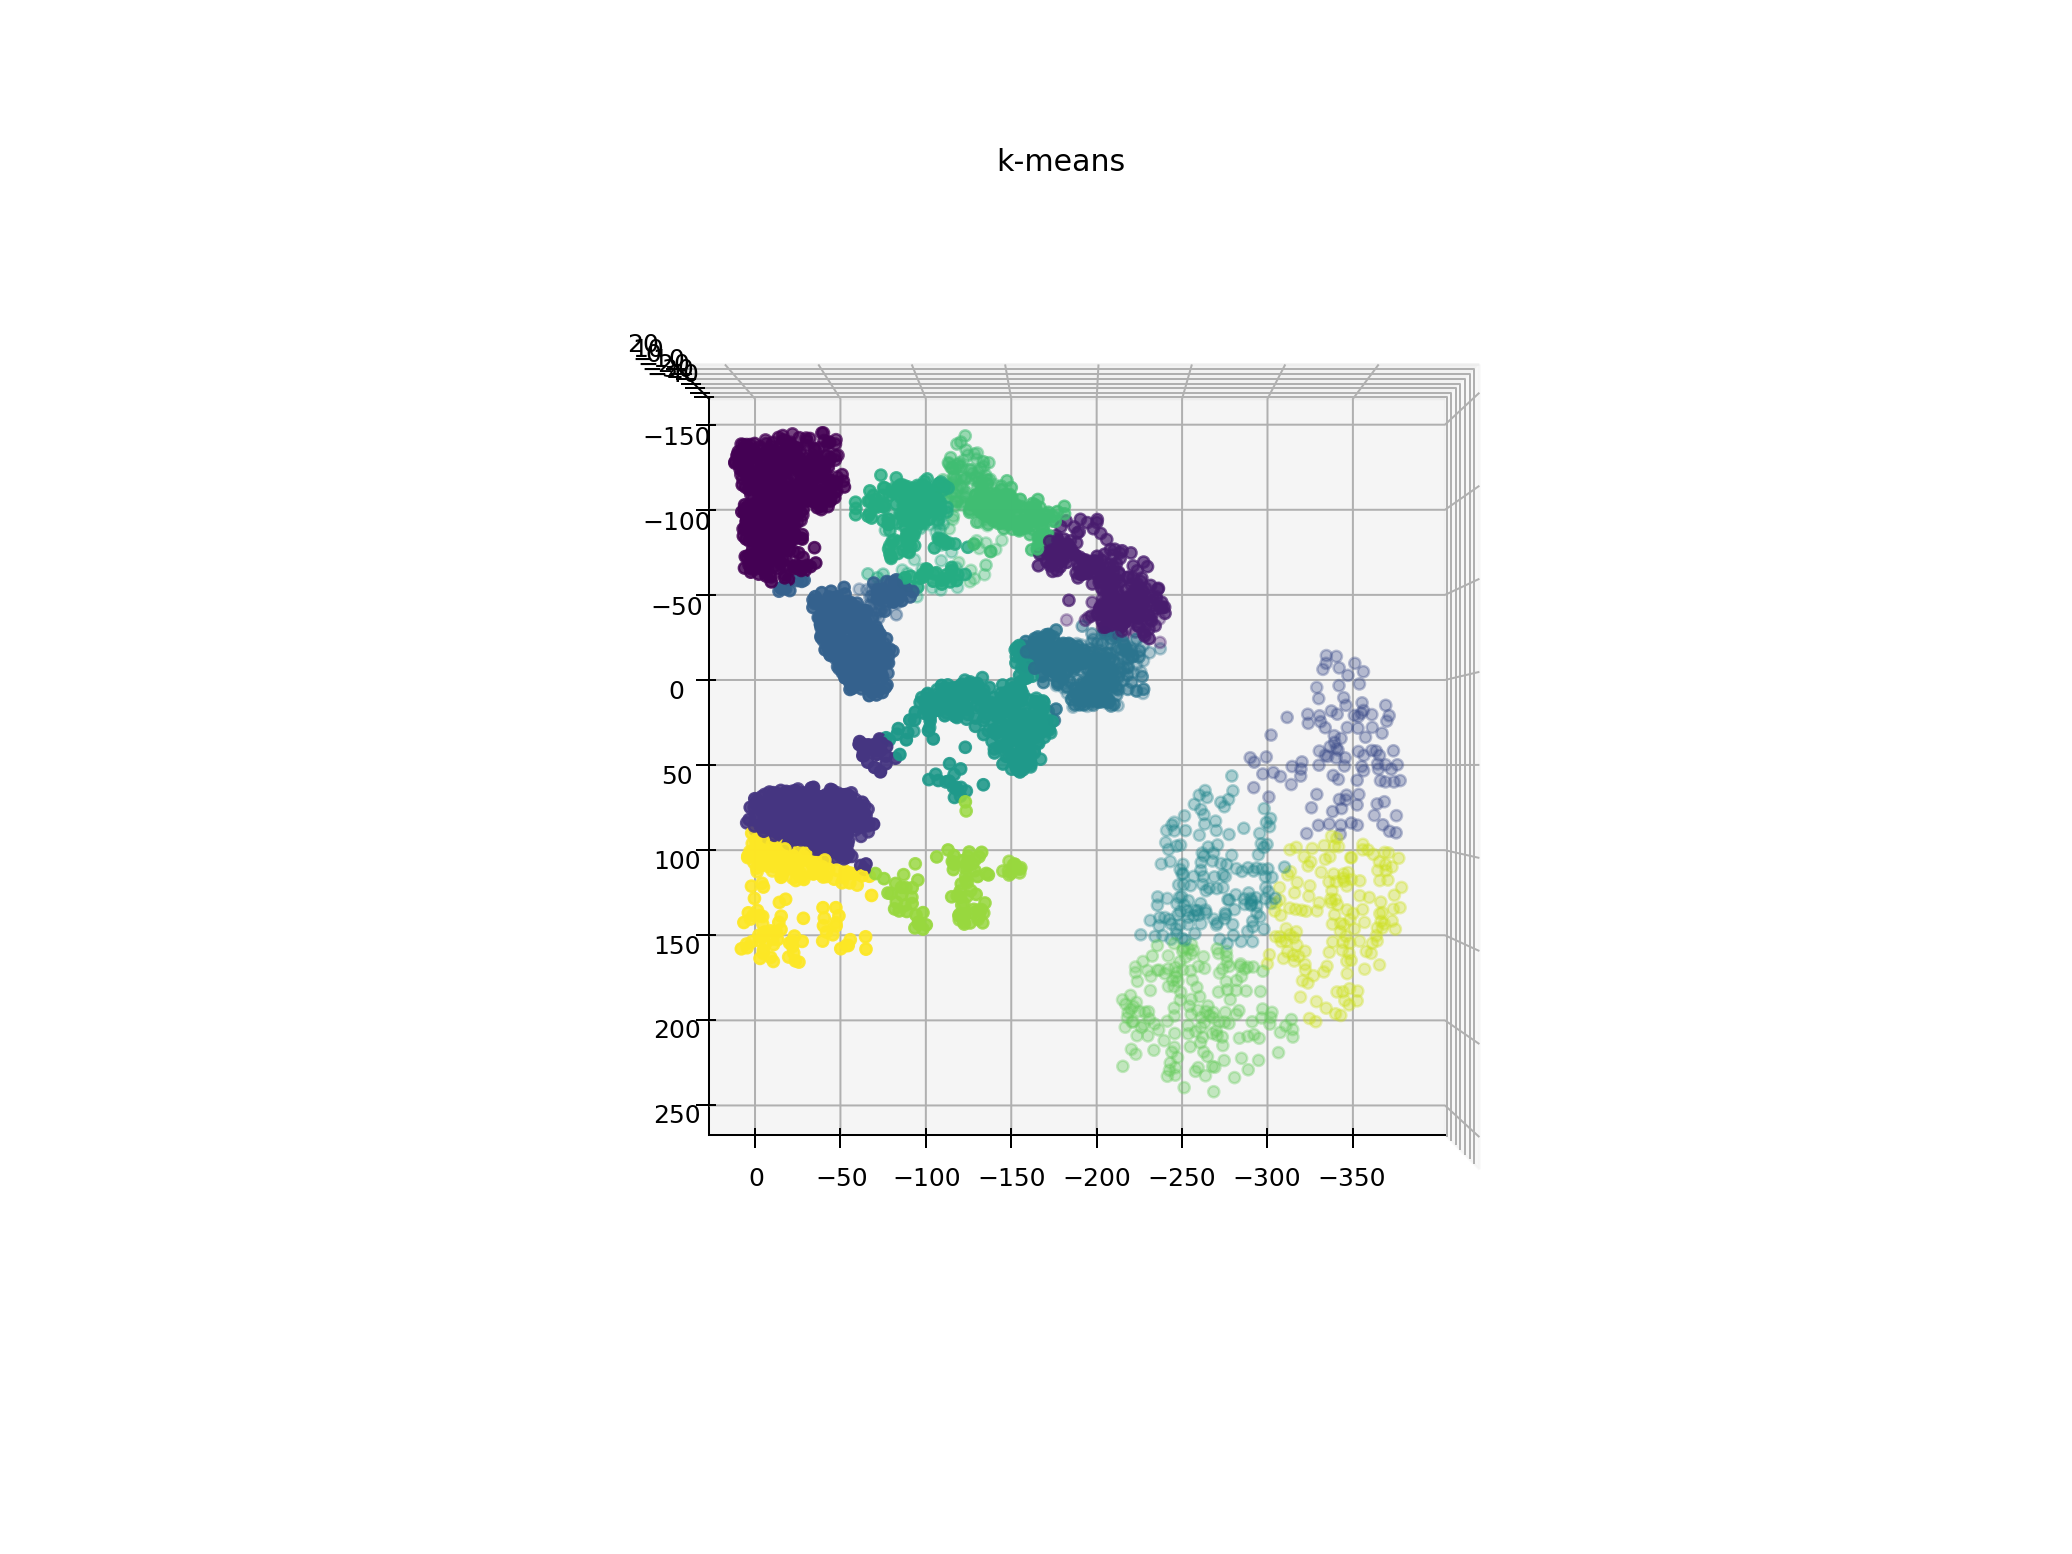

In [91]:
fitted_kmeans = kmeans_model.fit(data['mel_1_l'])
draw(data['mel_1_l'], fitted_kmeans.labels_, 'k-means', 'k-means')

# Hierarchical clustering

In [92]:
from sklearn.cluster import AgglomerativeClustering

agglomerative_model = AgglomerativeClustering(n_clusters=21, linkage='ward')

<IPython.core.display.Javascript object>


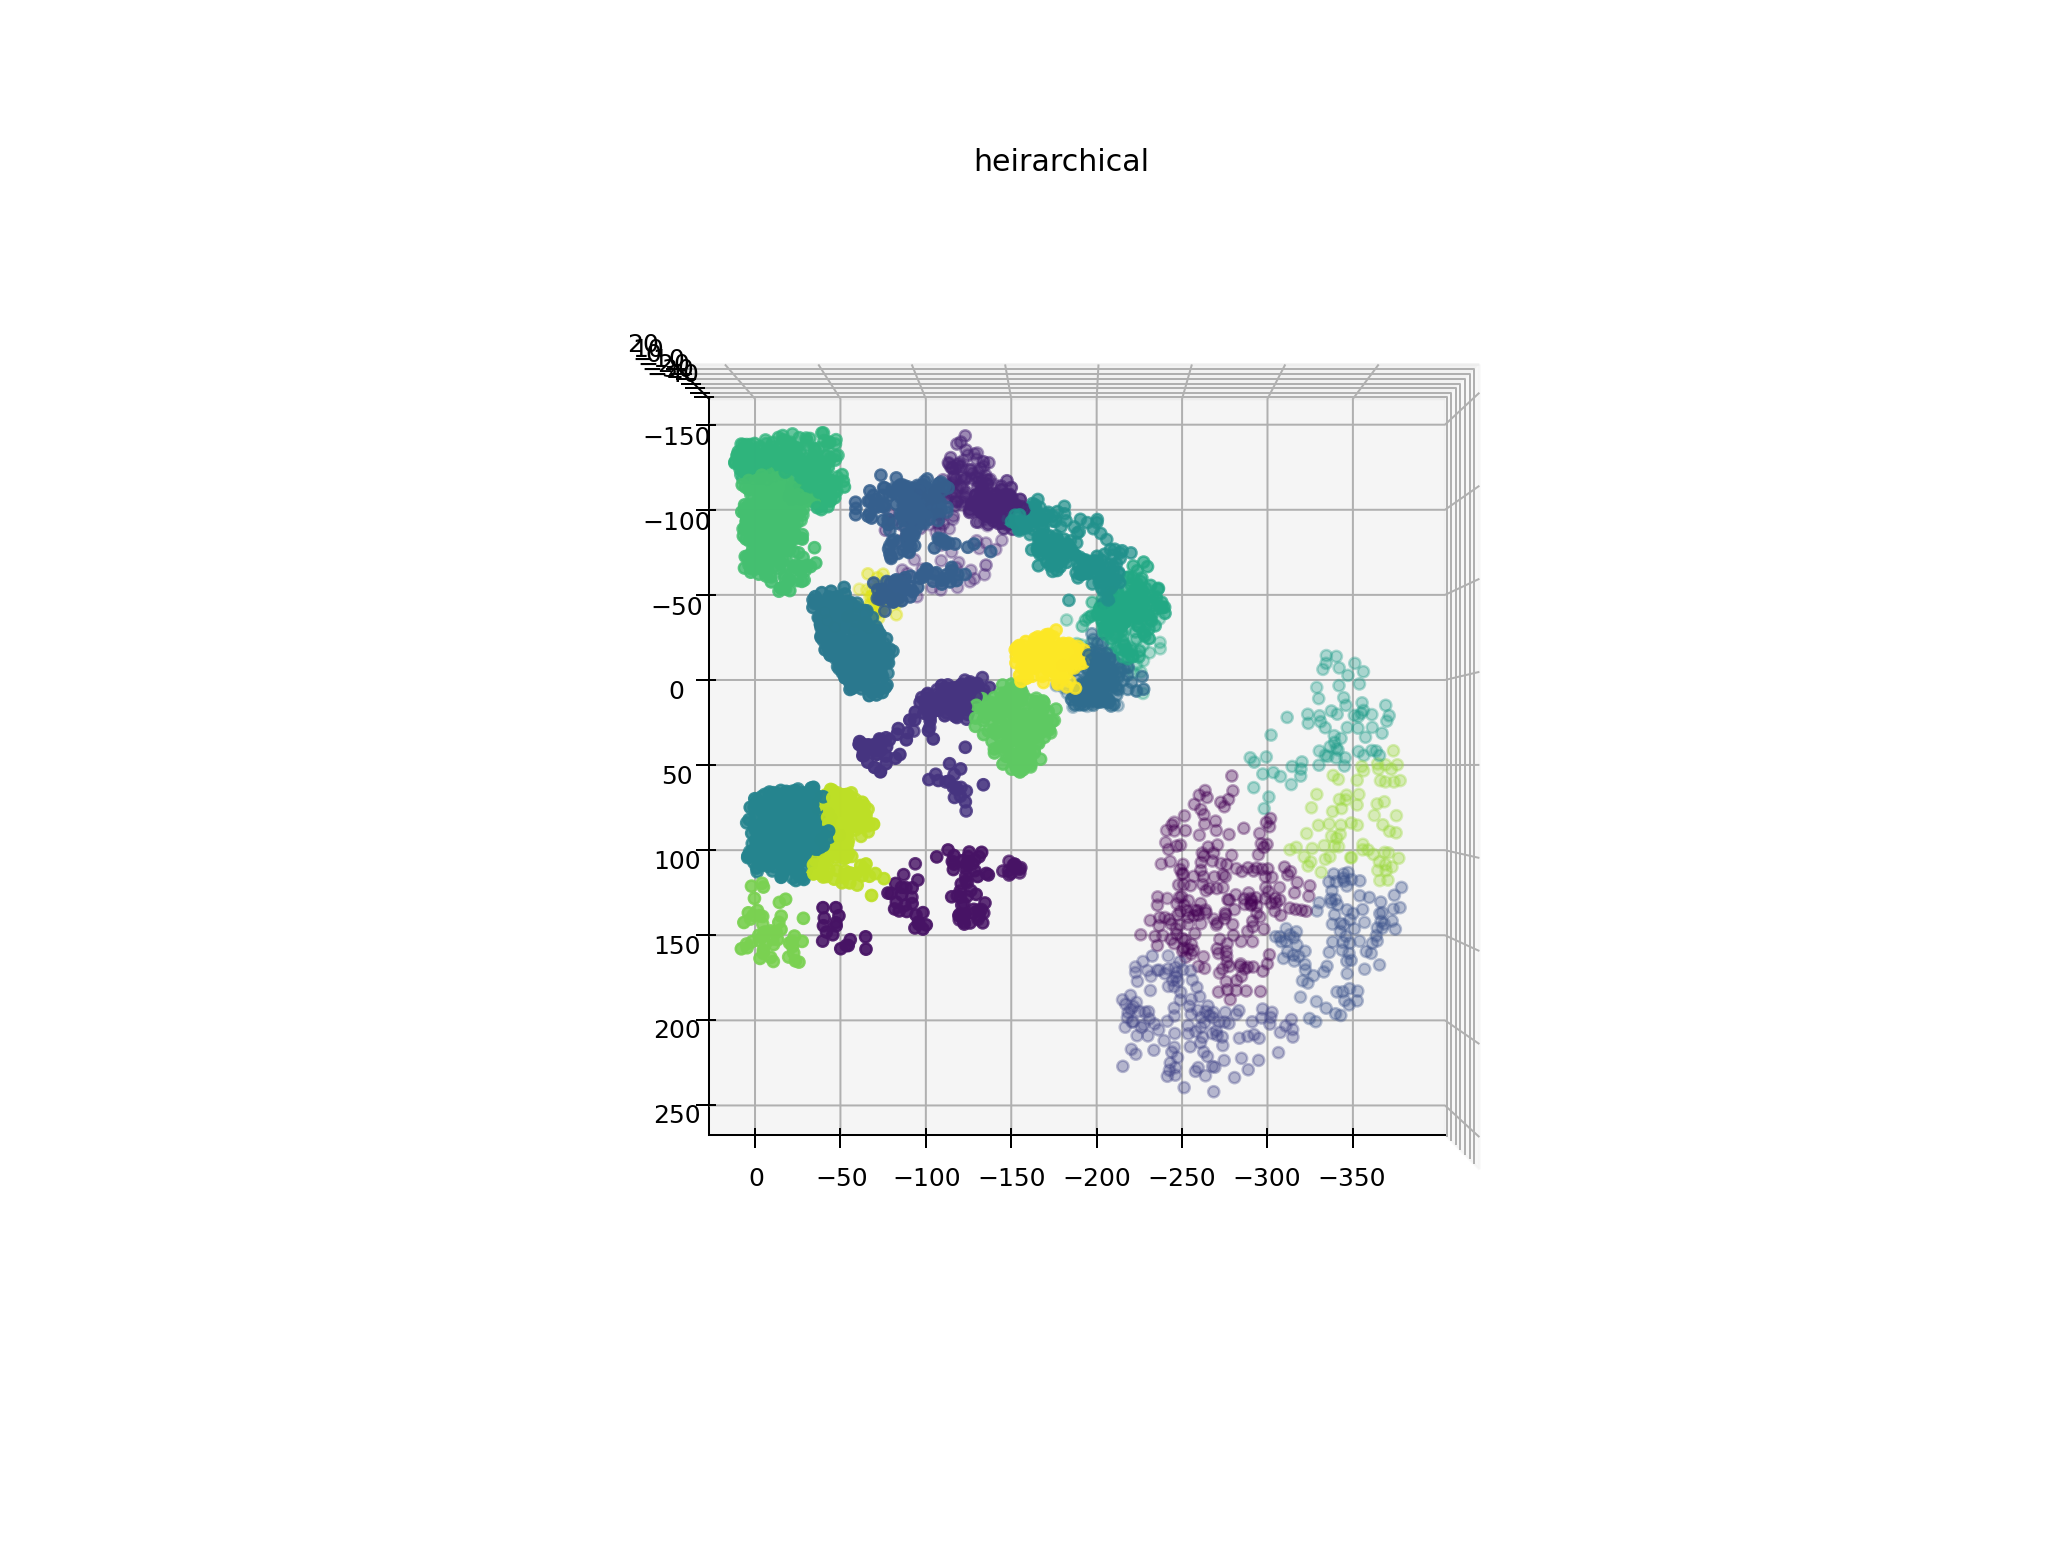

In [103]:
fitted_agglomerative = agglomerative_model.fit(data['mel_1_l'])
draw(data['mel_1_l'], fitted_agglomerative.labels_, 'heirarchical', 'heirarchical')

# DBSCAN

In [94]:
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=9).fit(data['mel_1_l'])

<IPython.core.display.Javascript object>


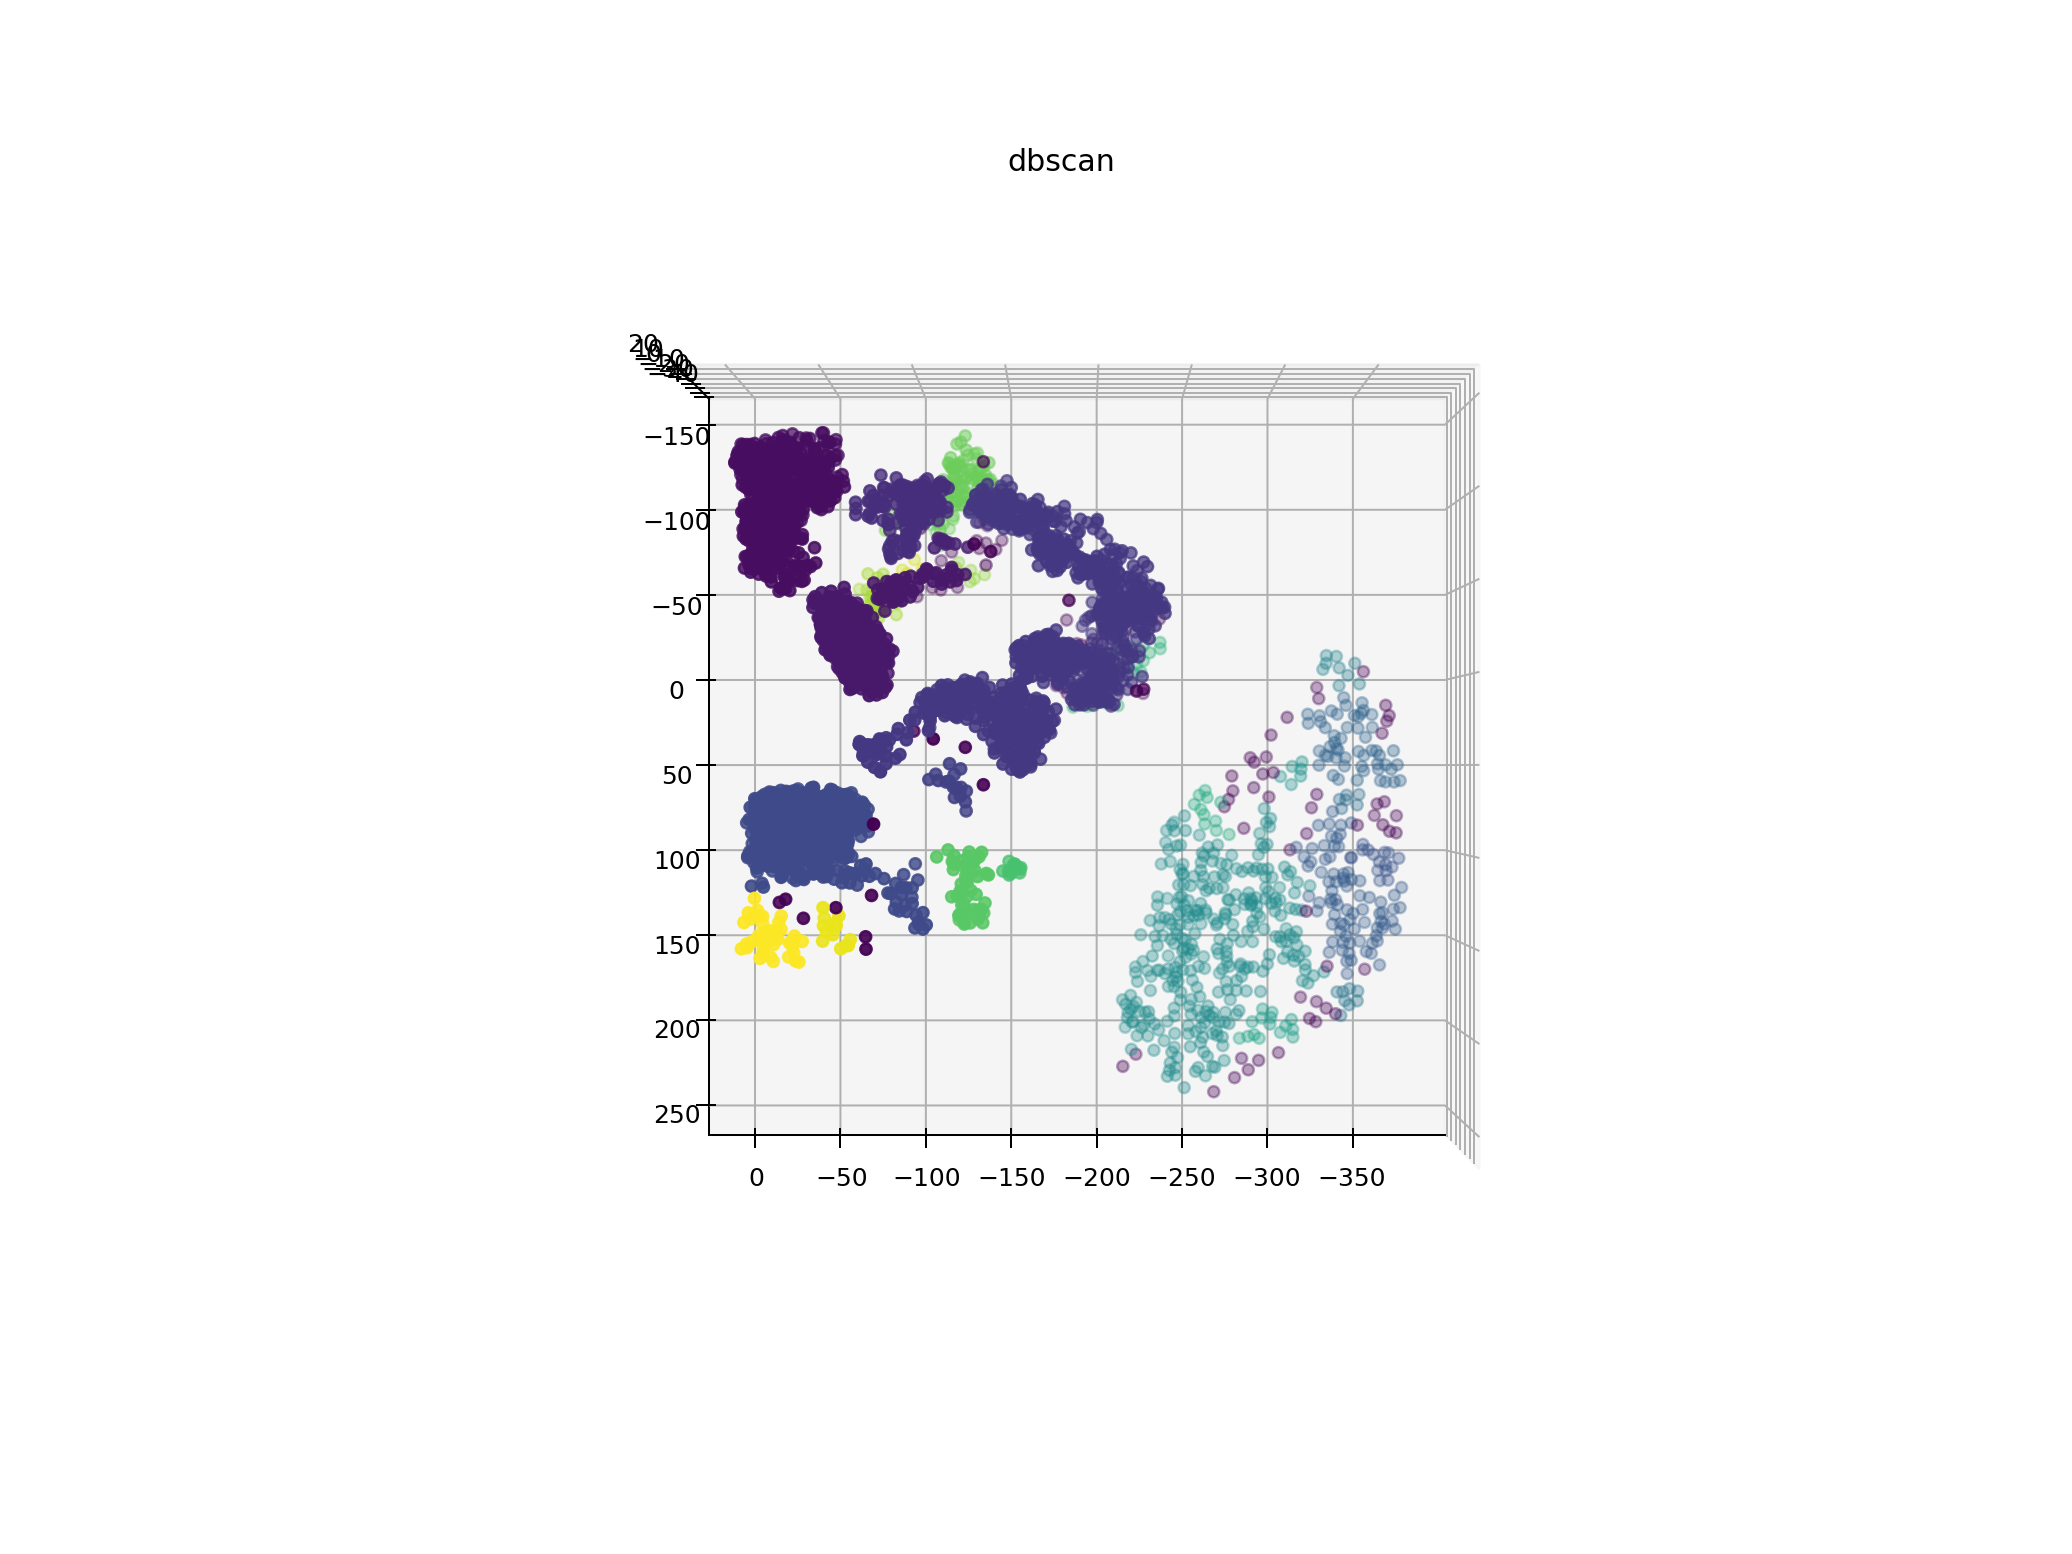

In [102]:
draw(data['mel_1_l'], dbscan_model.labels_, 'dbscan', 'dbscan')

# OPTICS

In [100]:
from sklearn.cluster import OPTICS

optics_model = OPTICS(metric='minkowski', p=1).fit(data['mel_1_l'])

<IPython.core.display.Javascript object>


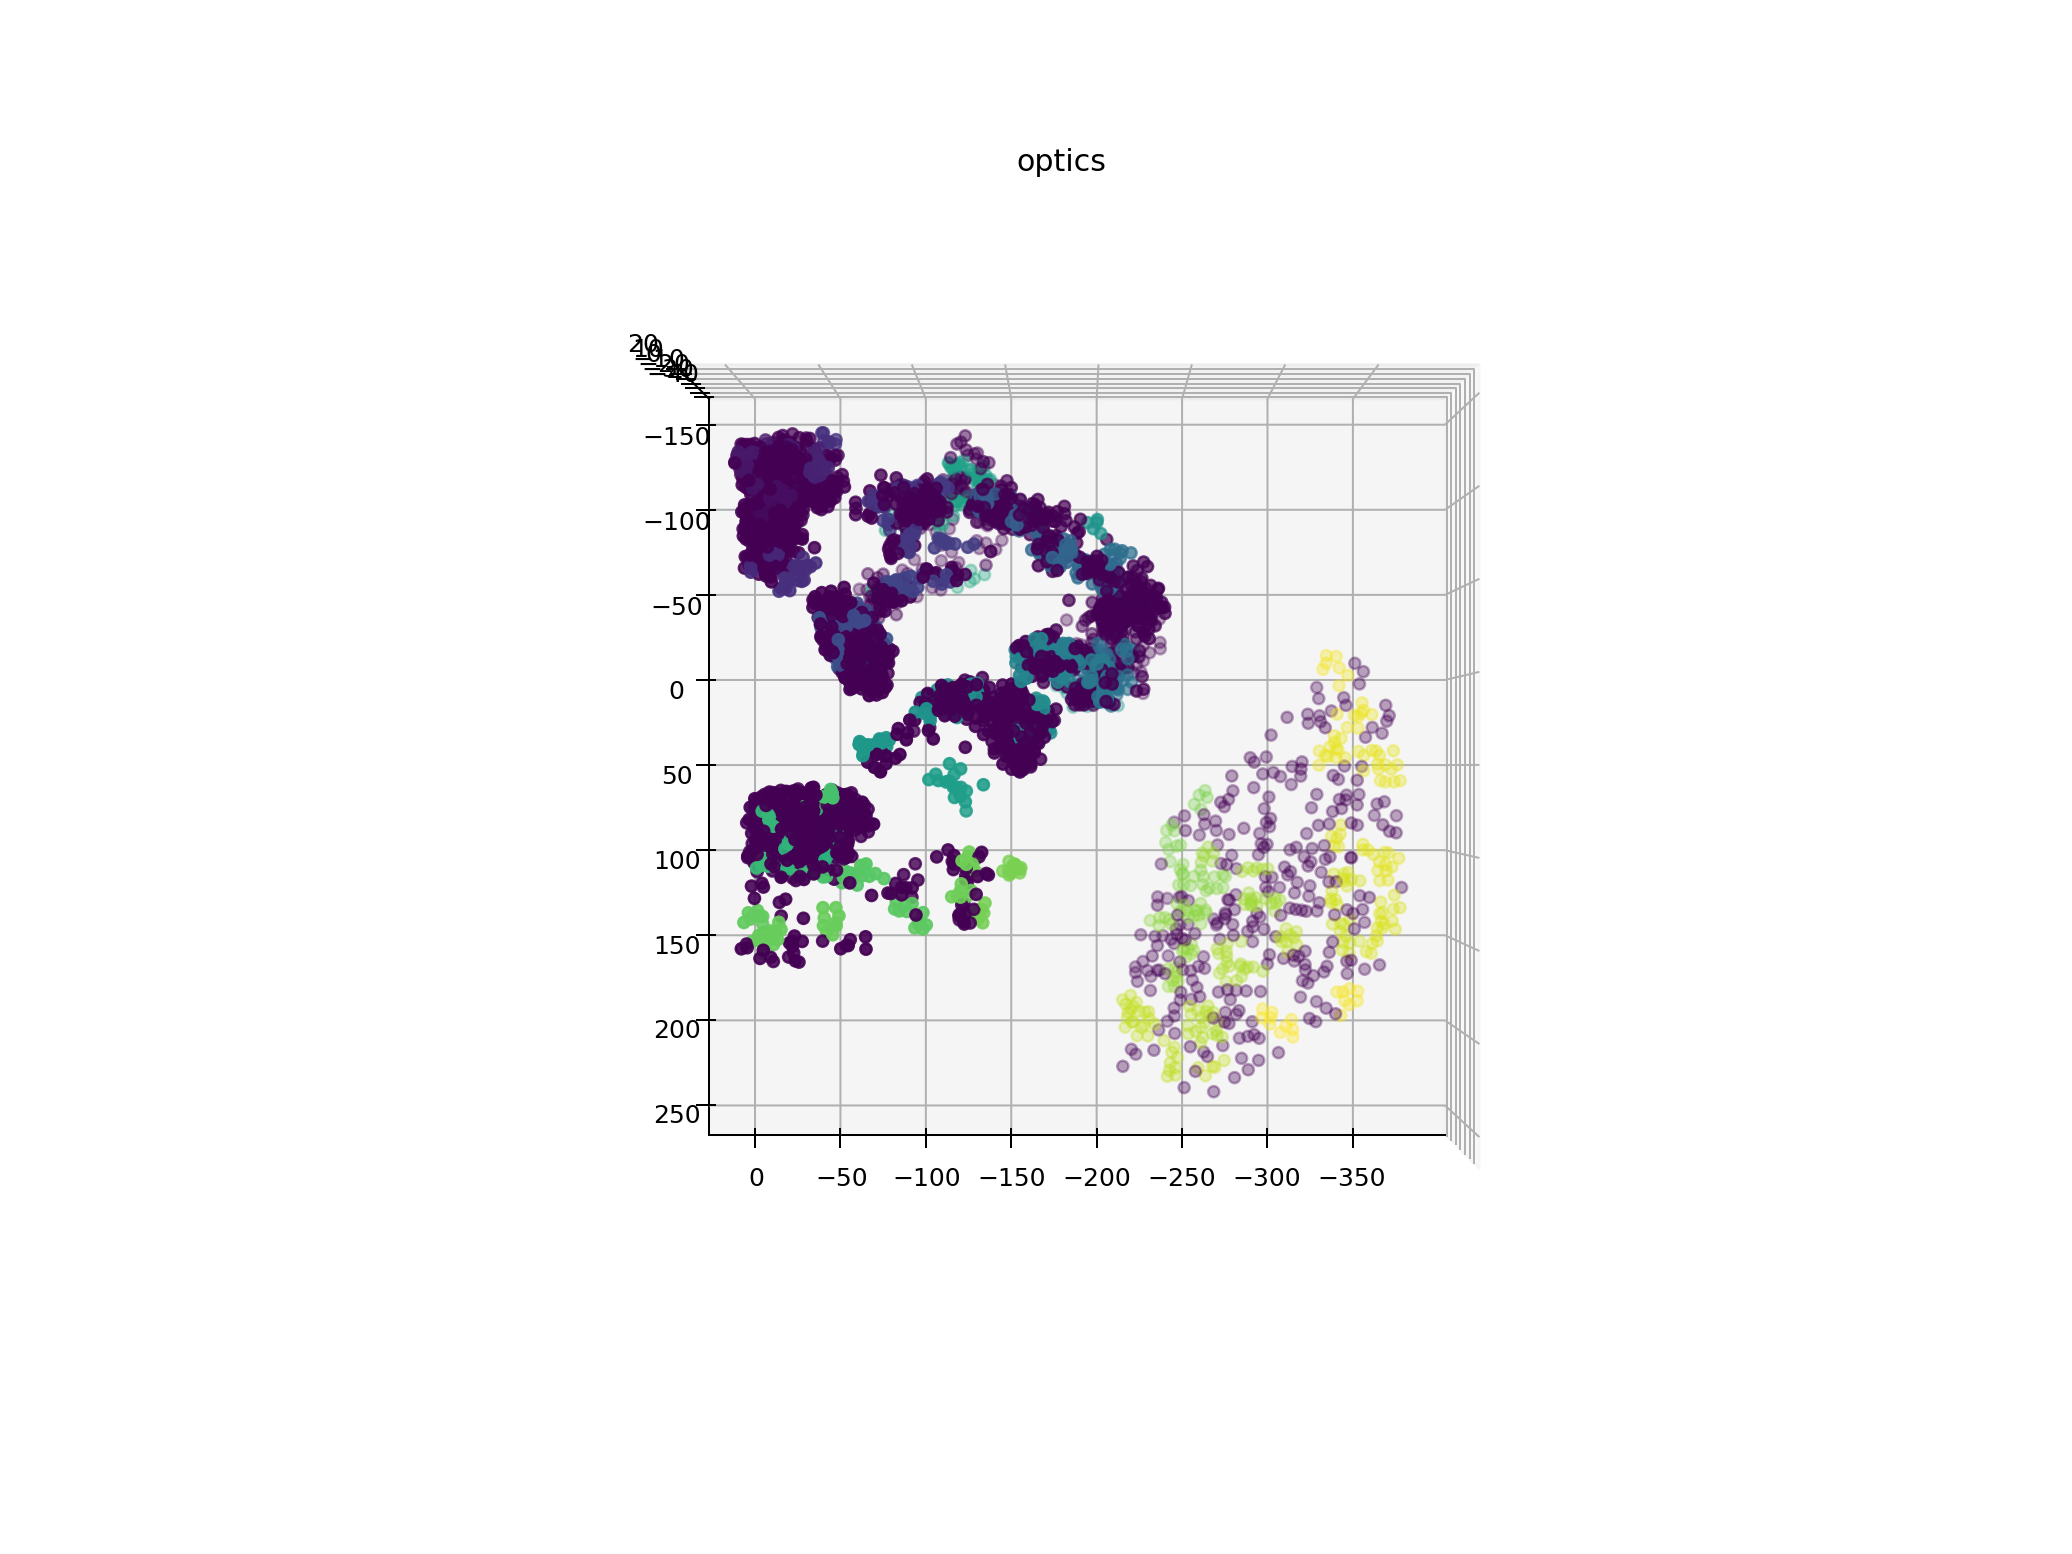

In [101]:
draw(data['mel_1_l'], optics_model.labels_, 'optics', 'optics')

# Birch

In [98]:
from sklearn.cluster import Birch

birch_model = Birch(n_clusters=21)

<IPython.core.display.Javascript object>


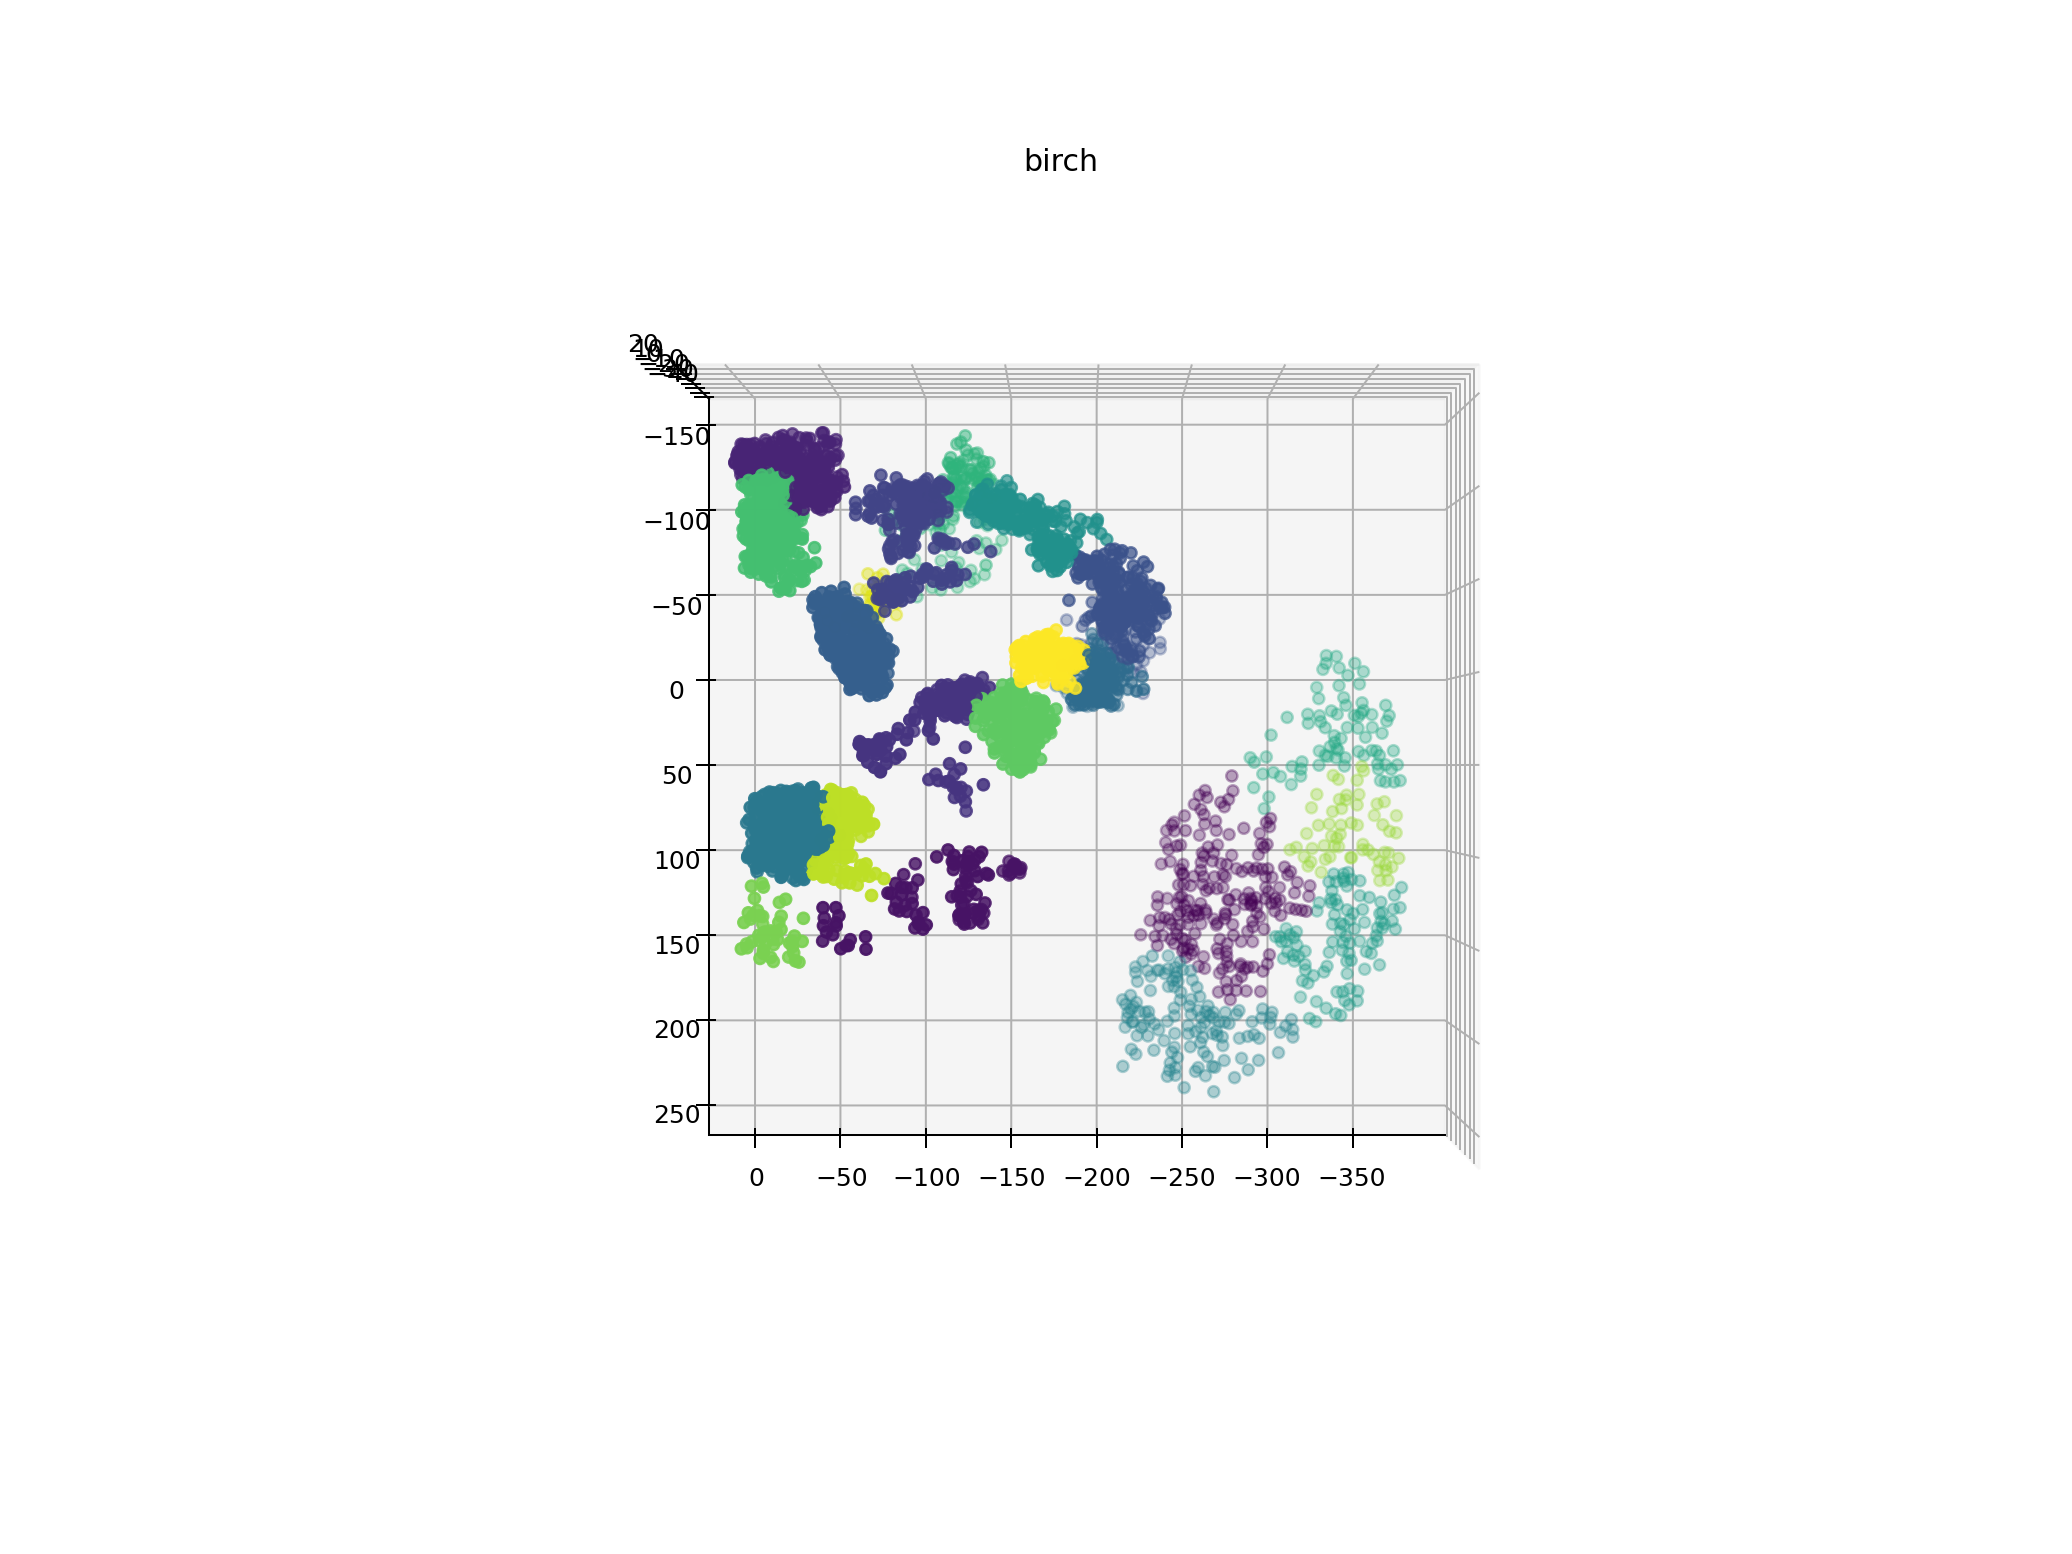

In [104]:
fitted_birch = birch_model.fit(data['mel_1_l'])
draw(data['mel_1_l'], fitted_birch.labels_, 'birch', 'birch')

In [81]:
def write_table(name, target, labels):
    target_keys = np.unique(target)
    target_values = [i for i in range(len(target_keys))]
    target_map = {target_keys[i]: target_values[i] for i in range(len(target_keys))}

    labels_keys = np.unique(labels)
    labels_values = [i for i in range(len(labels_keys))]
    labels_map = {labels_keys[i]: labels_values[i] for i in range(len(labels_keys))}

    table = np.array([[0.] * len(target_keys)] * len(labels_keys))

    number_of_points = [0] * len(target_keys)

    for index in range(len(target)):
        target_index = target_map[target[index]]
        label_index = labels_map[labels[index]]
        number_of_points[target_index] += 1
        table[label_index][target_index] += 1

    for target_key in target_keys:
        target_index = target_map[target_key]

        for index in range(len(labels_keys)):
            table[index, target_index] /= number_of_points[target_index]

    table = np.transpose(table)
    data = pd.DataFrame(table, index=target_keys, columns=labels_keys)
    data.to_csv(name)
    
    
def write_partition(vertex_ides, labels, path):
    with open(path, 'w') as partition:
        partition.write('1\n')
            
        for label in np.unique(labels):
            sub_vertices = vertex_ides[labels == label]
            partition.write(' '.join(list(map(str, np.reshape(sub_vertices, len(sub_vertices))))) + '\n')

In [86]:
os.system('cp ../metric/cmake-build-release/metric metric')

def pipeline(model, title):
    paths = ['../pipeline/zonetab-mel-animal-1-l', 
             '../pipeline/zonetab-mel-animal-1-r', 
             '../pipeline/zonetab-mel-animal-2-l', 
             '../pipeline/zonetab-mel-animal-2-r',
             '../pipeline/zonetab-mel-animal-3-l',
             '../pipeline/zonetab-mel-animal-3-r',
             '../pipeline/zonetab-sim-animal-2-l',
             '../pipeline/zonetab-sim-animal-2-r',
             '../pipeline/zonetab-sim-animal-3-l',
             '../pipeline/zonetab-sim-animal-3-r',
             '../pipeline/zonetab-sim-animal-4-l',
             '../pipeline/zonetab-sim-animal-4-r']
    
    for path_id in range(len(paths)):
        brain = pd.read_csv(paths[path_id] + os.sep + 'data.csv')
        vertex_ides = brain.iloc[:, [0]].to_numpy()
        brain_points = brain.iloc[:, [1, 2, 3]].to_numpy()
        fitted_model = model.fit(brain_points)
        labels = fitted_model.labels_
        path_to_partition = paths[path_id] + os.sep + f'{title}_partition.out'
        
        write_partition(vertex_ides, labels, path_to_partition)
        os.system(f'./metric -r {paths[path_id]}/real_partition.out -f {paths[path_id]}/{title}_partition.out '
                  f'-o {paths[path_id]}/{title}_metric_value')
        draw(brain_points, labels, title, paths[path_id] + os.sep + title)
        write_table(f'{paths[path_id] + os.sep + title}_vs_real.csv', brain.zone.values, labels)

<IPython.core.display.Javascript object>


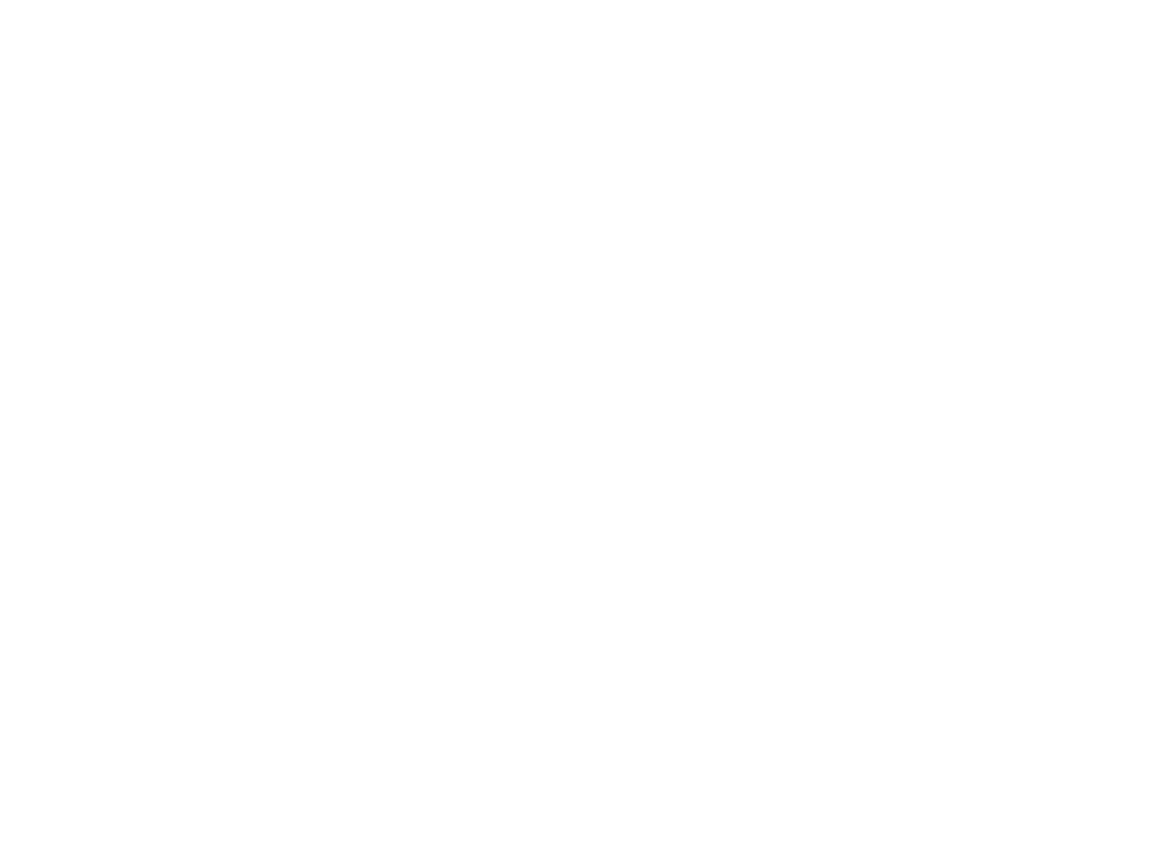

<IPython.core.display.Javascript object>


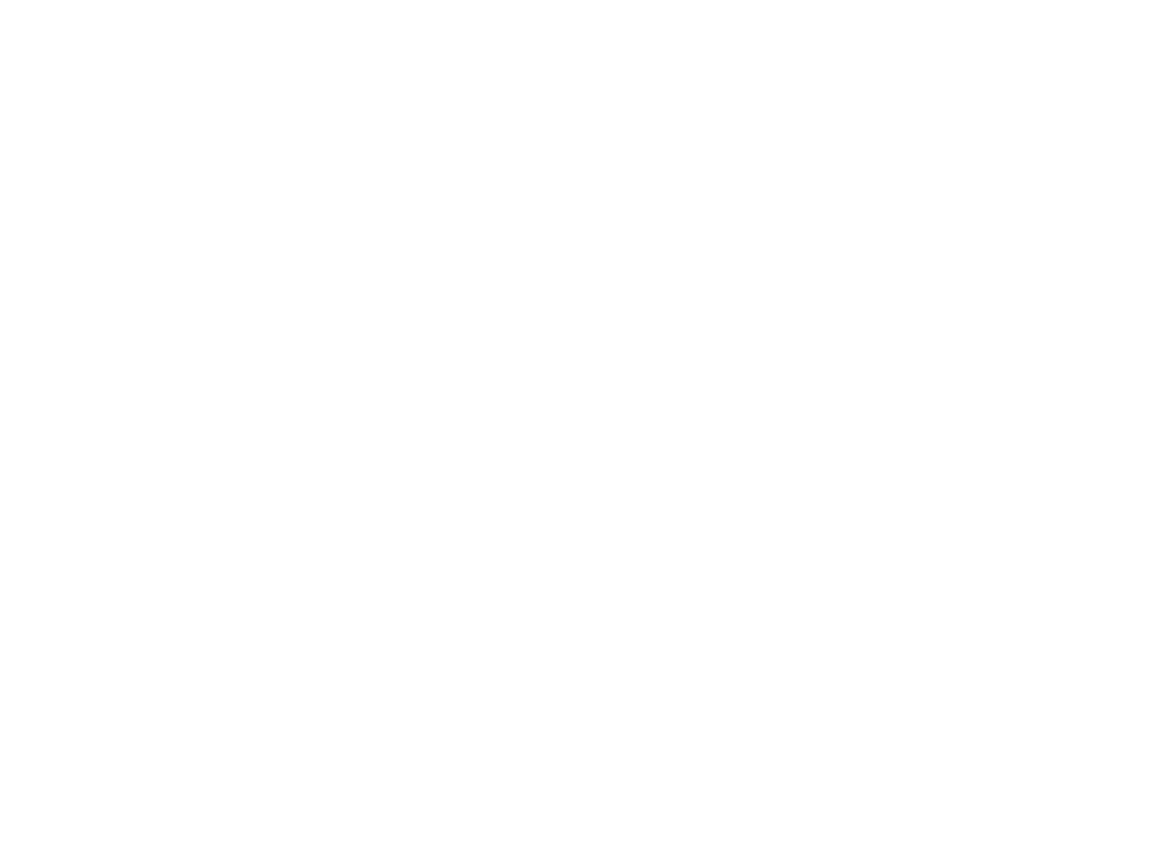

<IPython.core.display.Javascript object>


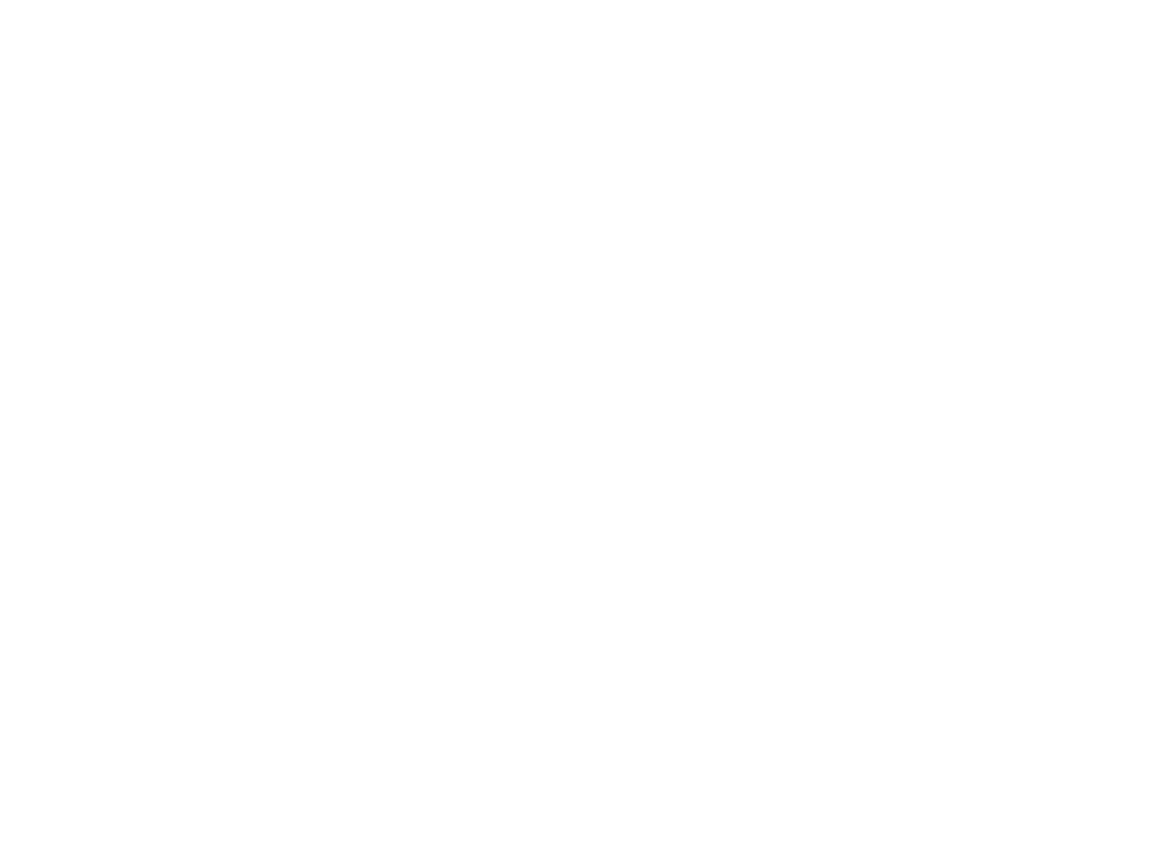

<IPython.core.display.Javascript object>


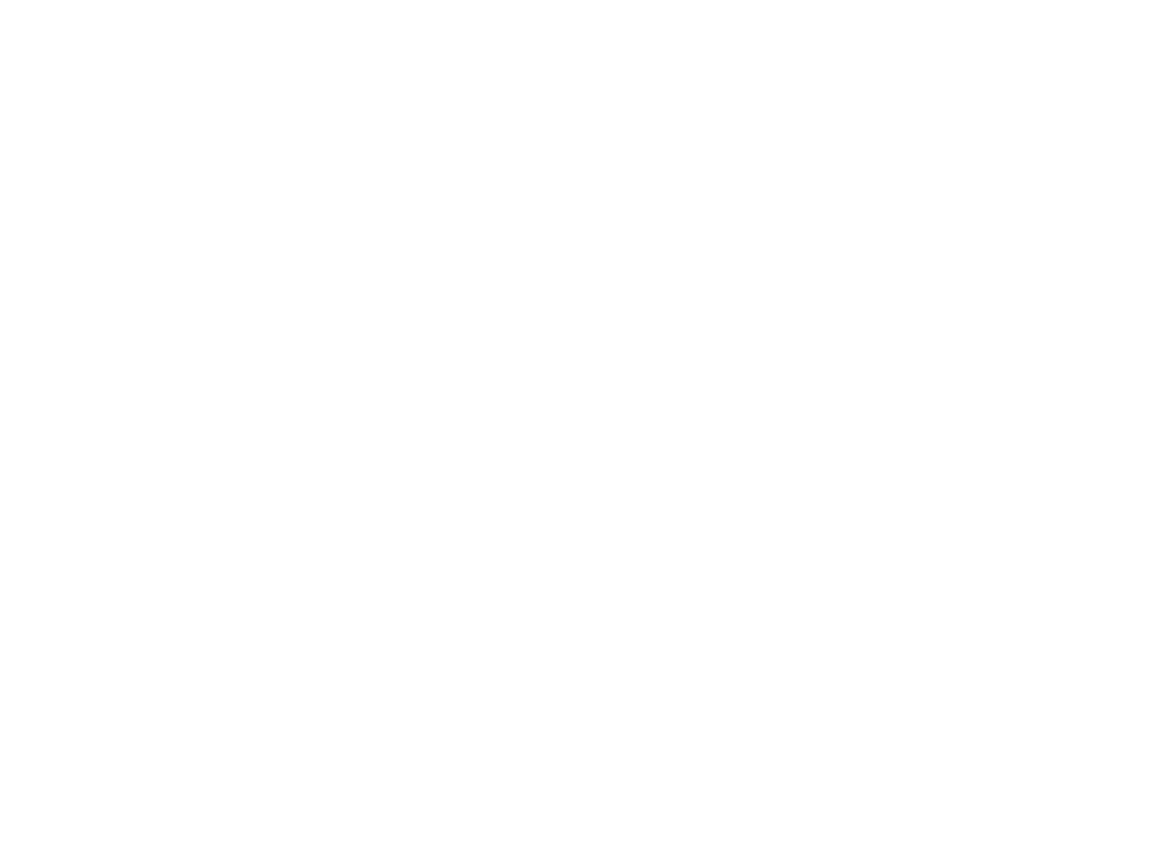

<IPython.core.display.Javascript object>


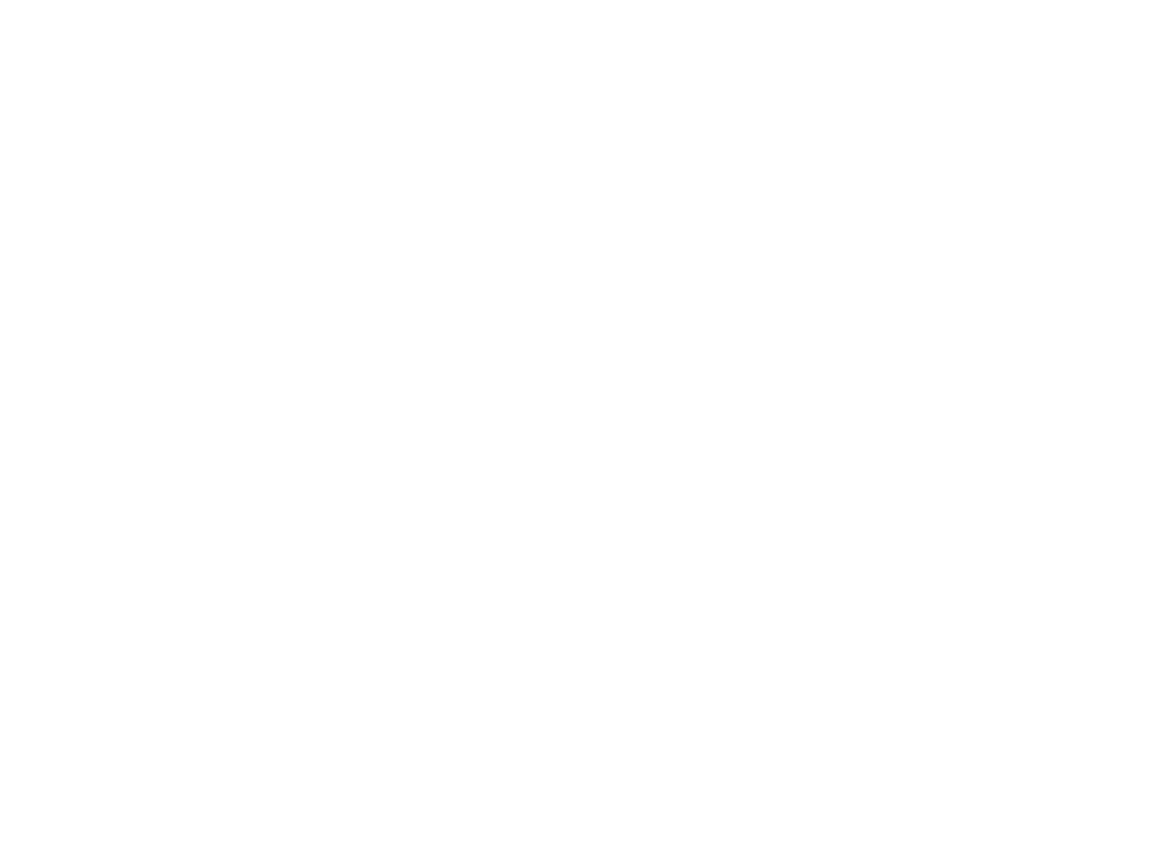

<IPython.core.display.Javascript object>


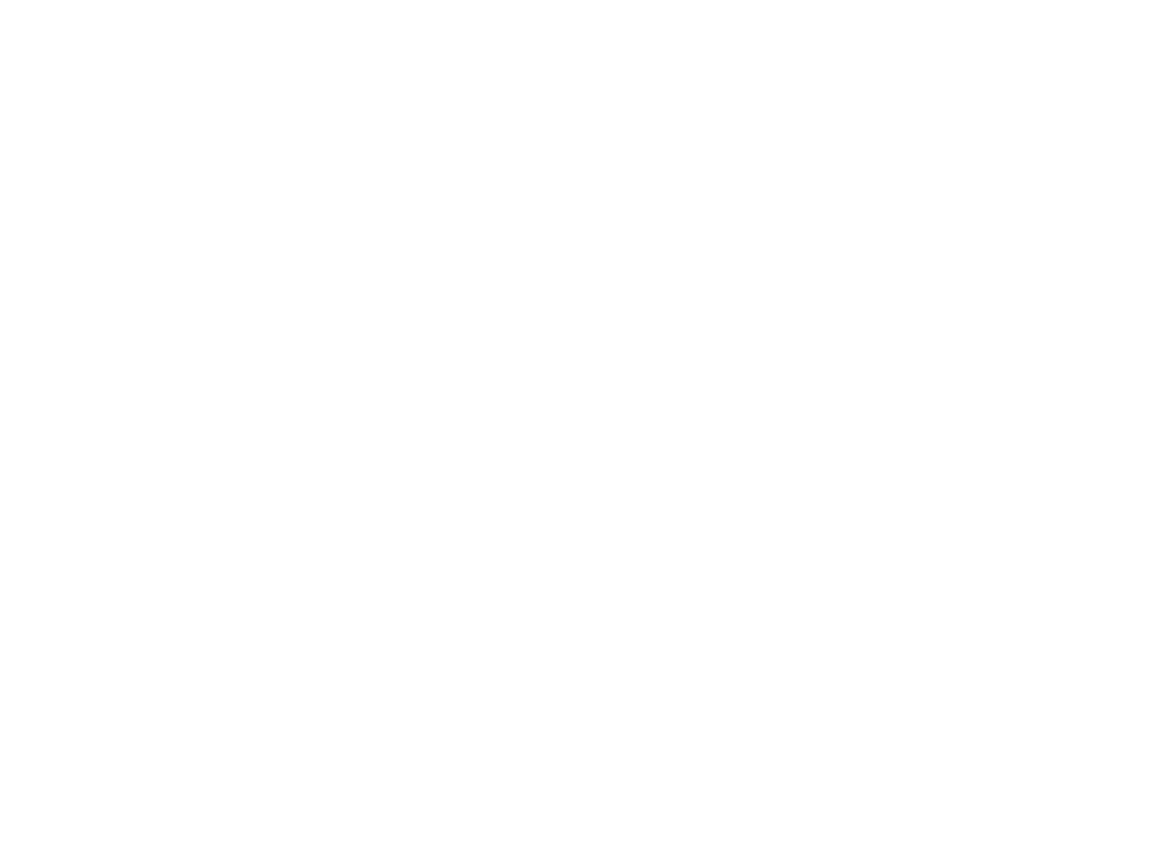

<IPython.core.display.Javascript object>


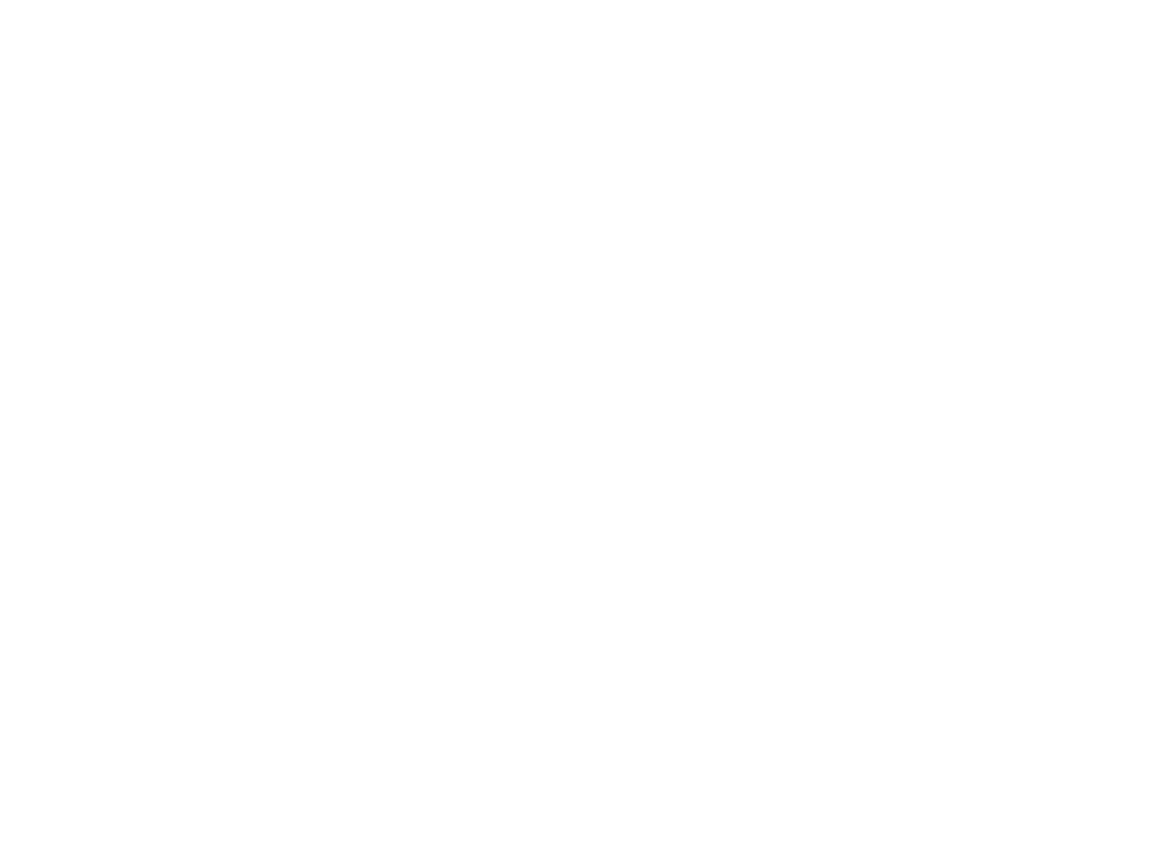

<IPython.core.display.Javascript object>


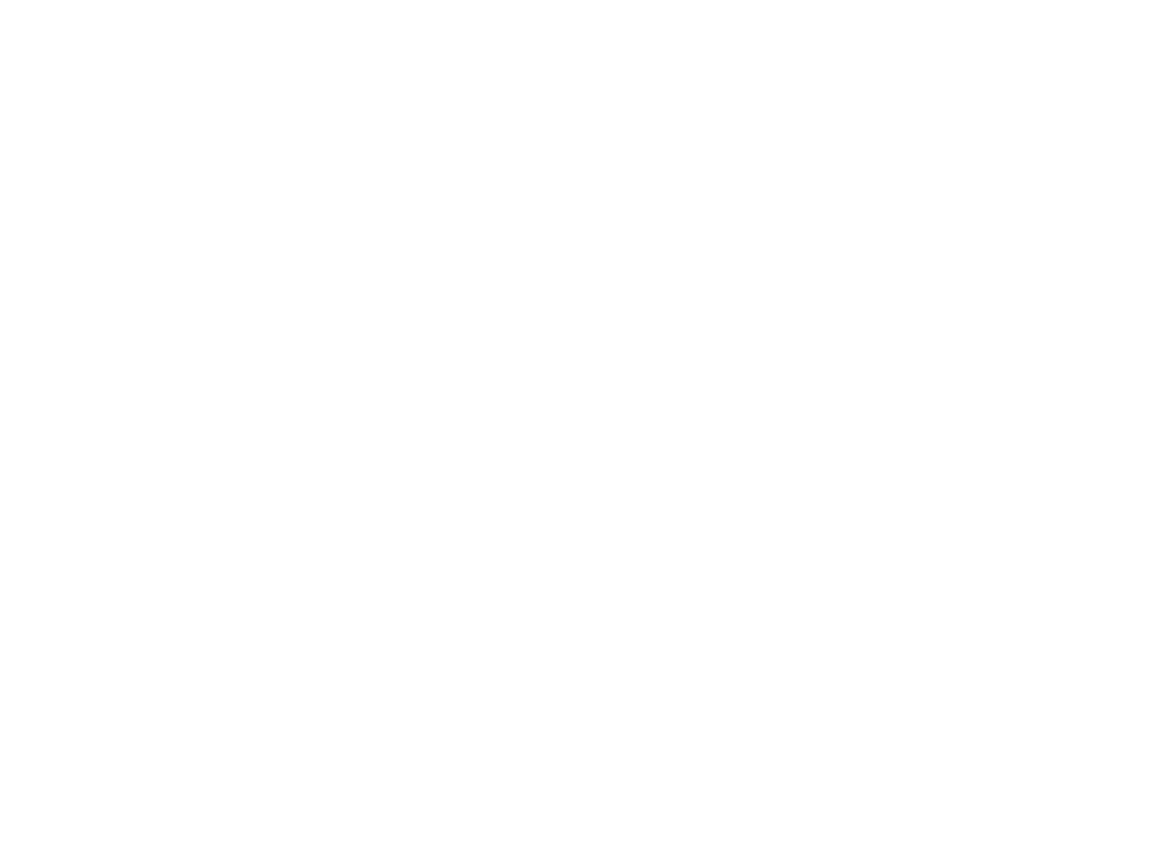

<IPython.core.display.Javascript object>


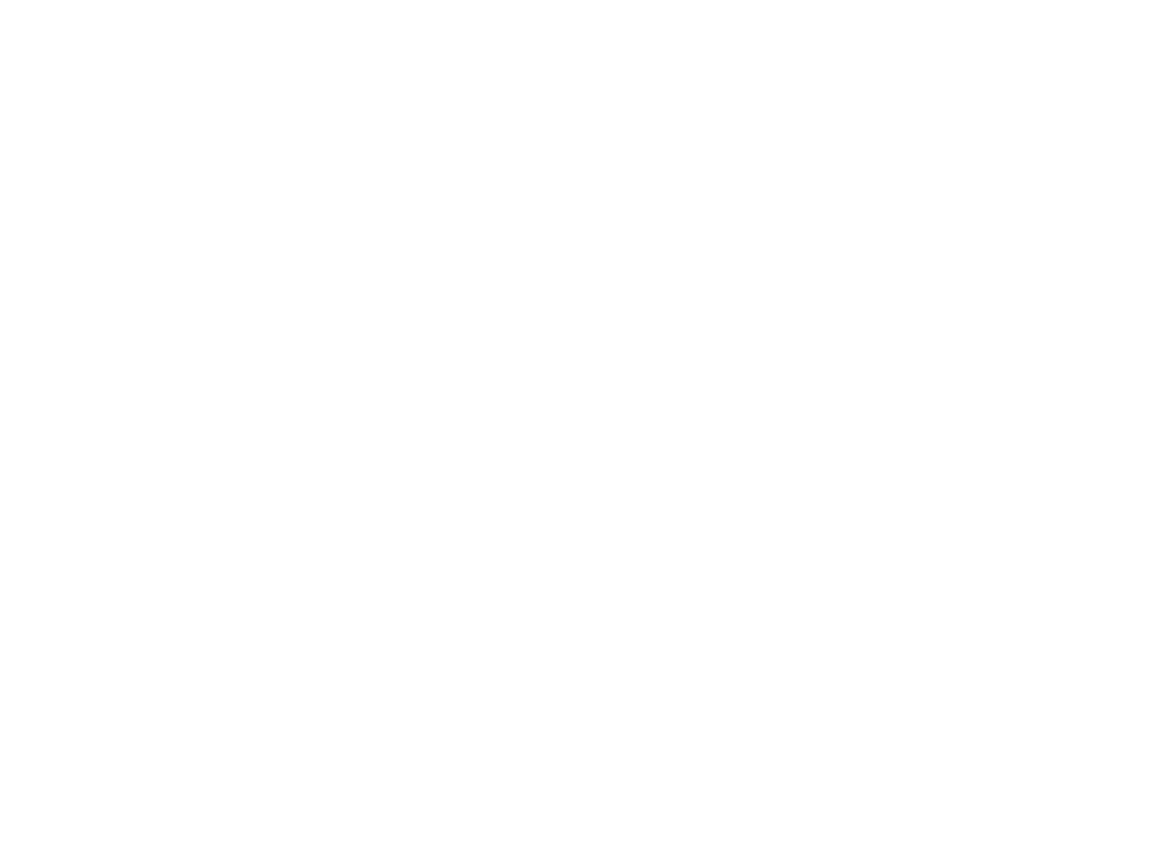

<IPython.core.display.Javascript object>


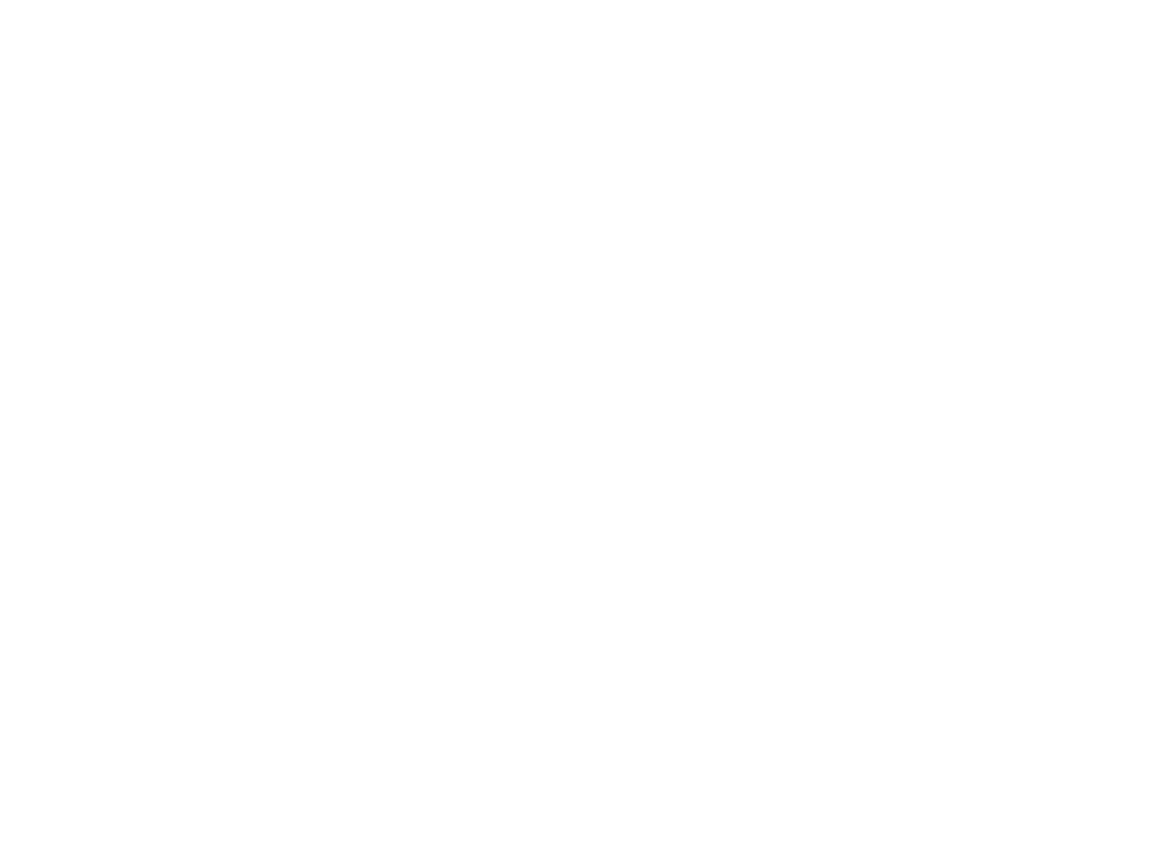

<IPython.core.display.Javascript object>


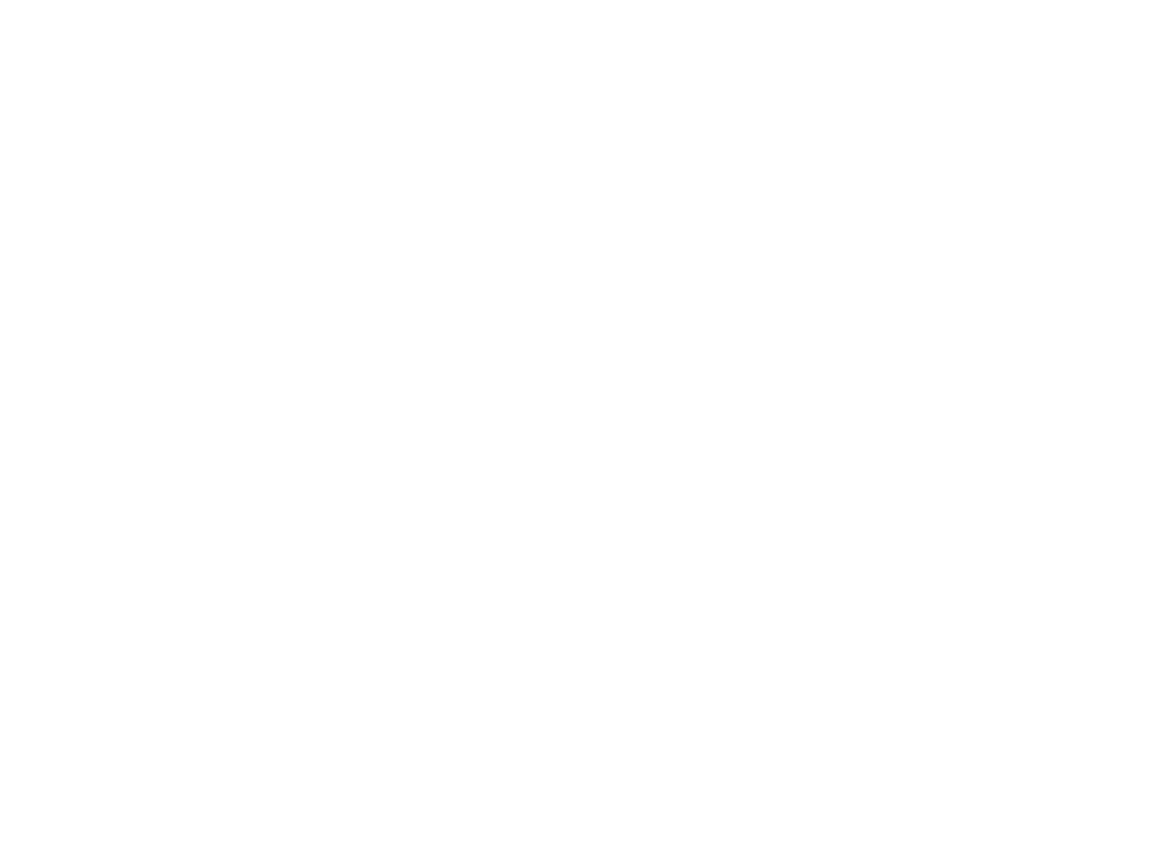

<IPython.core.display.Javascript object>


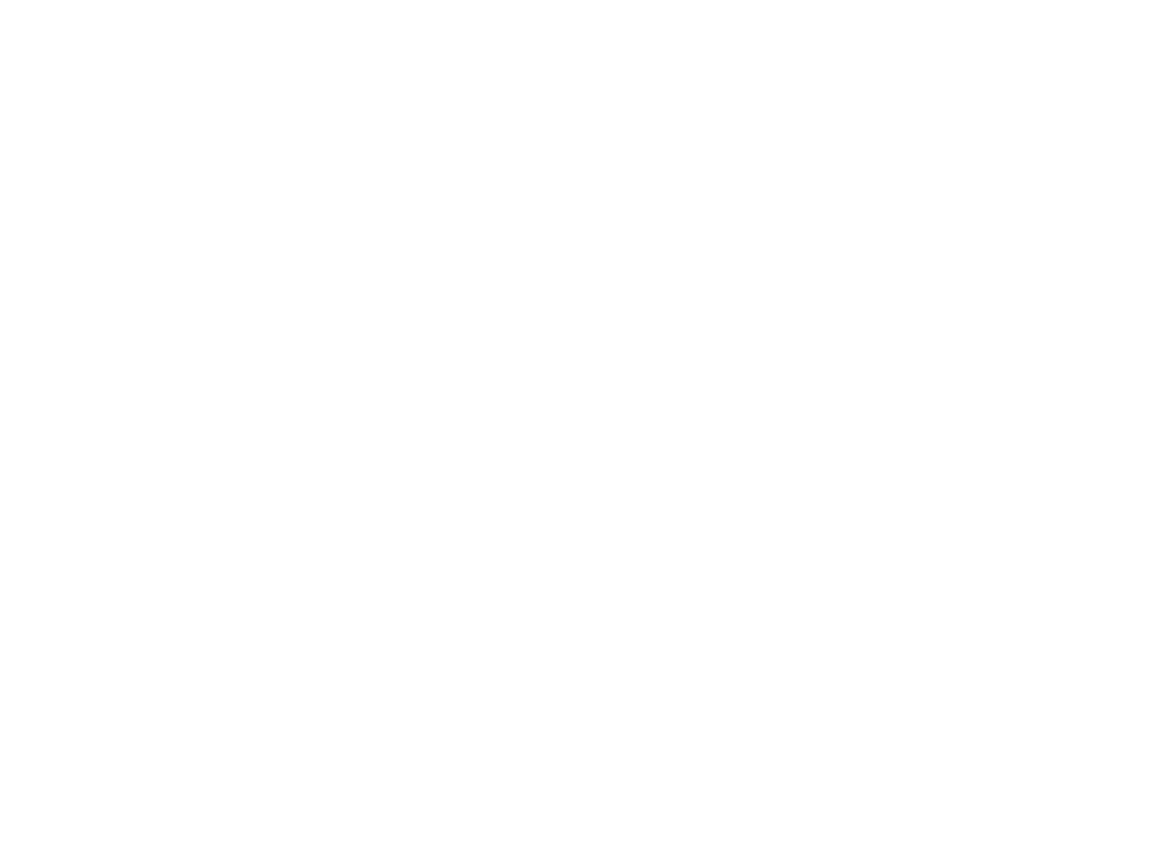

<IPython.core.display.Javascript object>


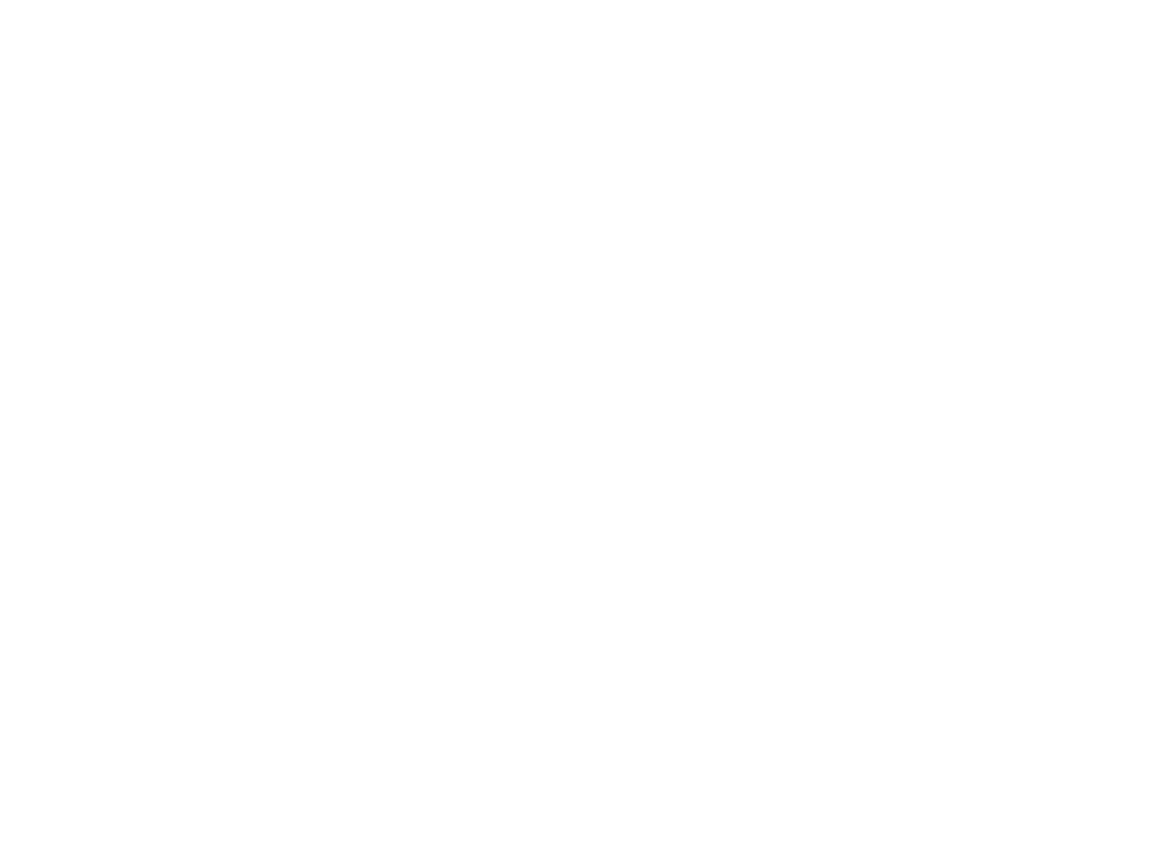

<IPython.core.display.Javascript object>


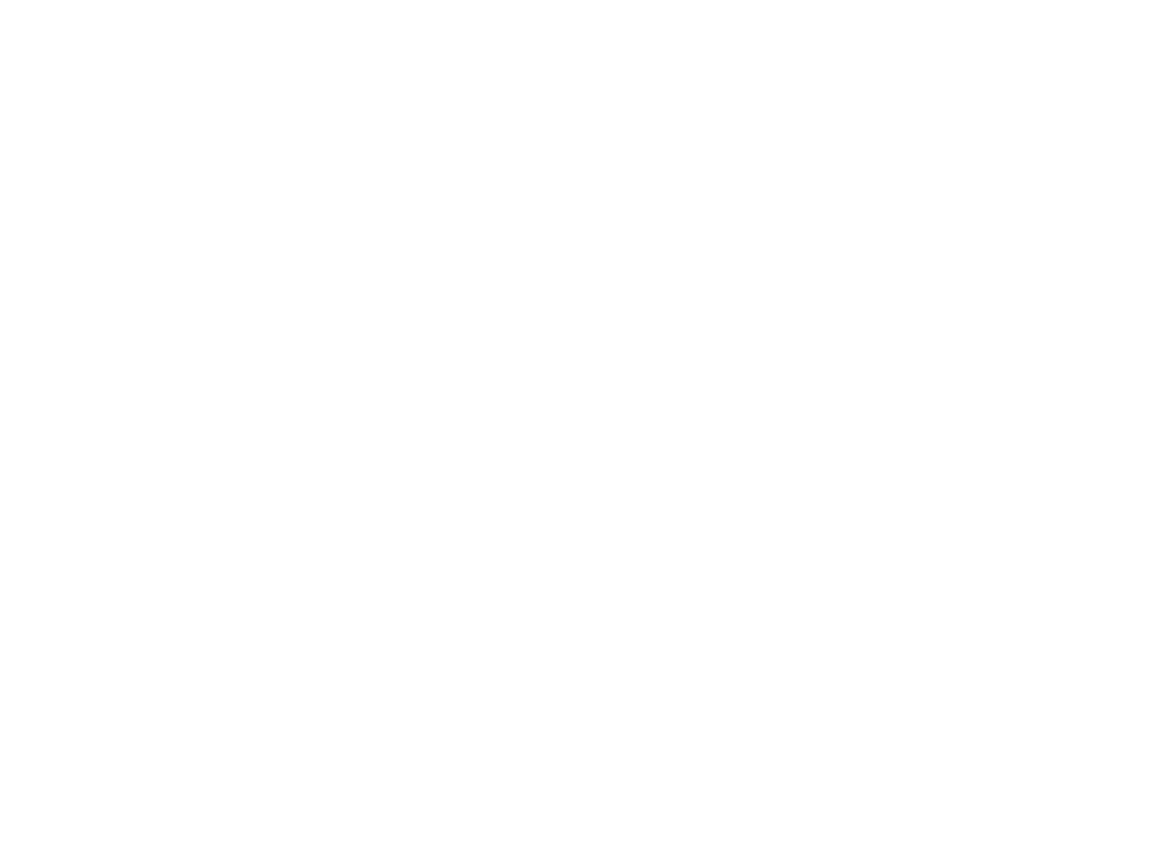

<IPython.core.display.Javascript object>


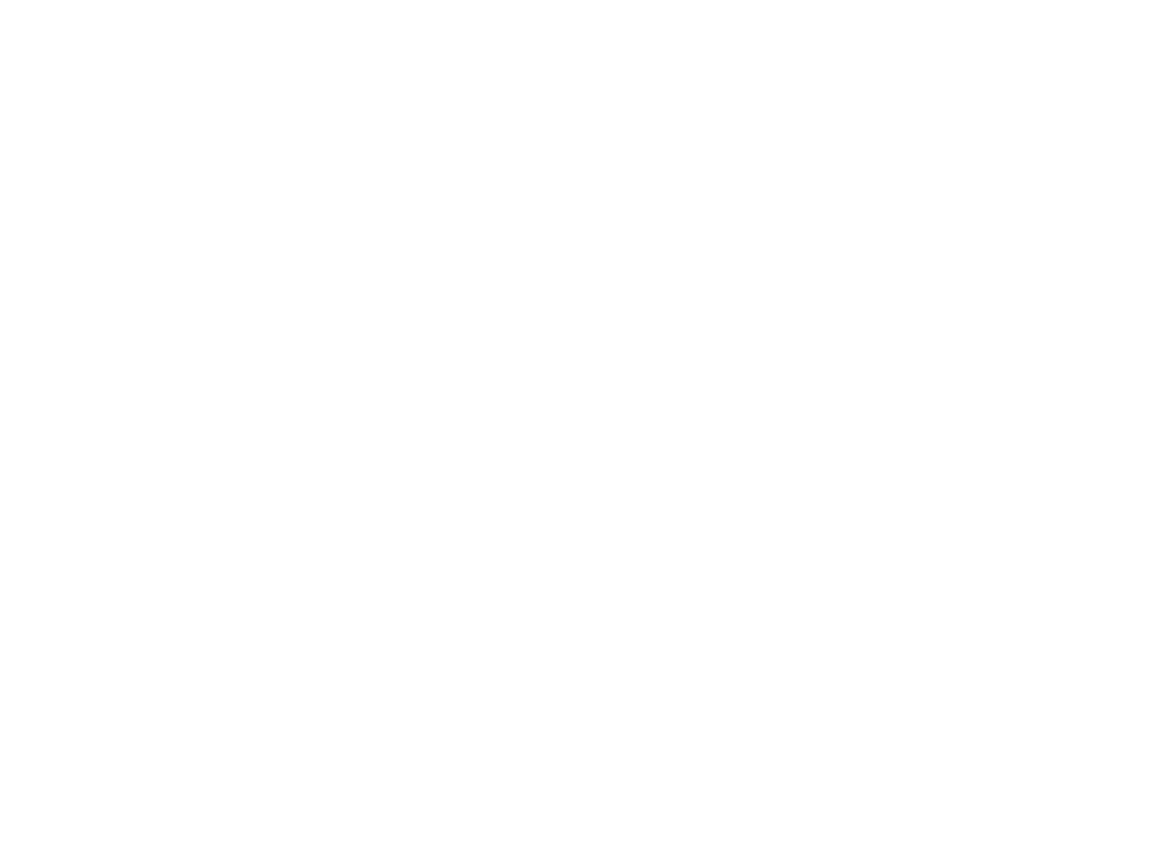

<IPython.core.display.Javascript object>


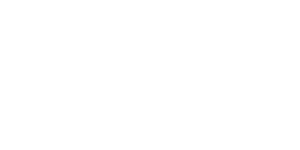

<IPython.core.display.Javascript object>


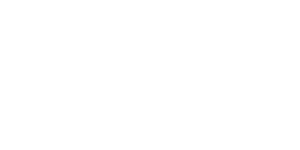

<IPython.core.display.Javascript object>


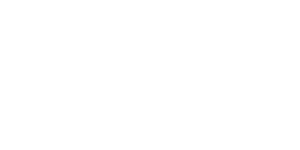

<IPython.core.display.Javascript object>


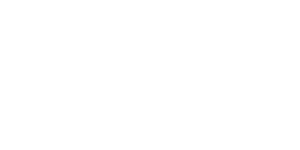

<IPython.core.display.Javascript object>


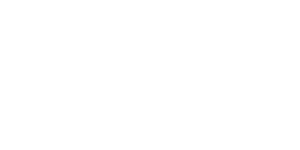

<IPython.core.display.Javascript object>


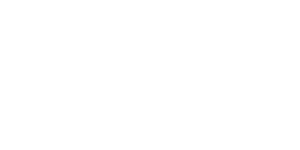

<IPython.core.display.Javascript object>


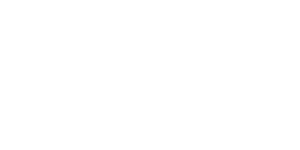

<IPython.core.display.Javascript object>


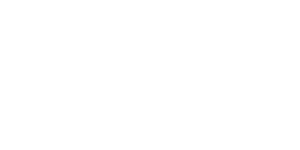

<IPython.core.display.Javascript object>


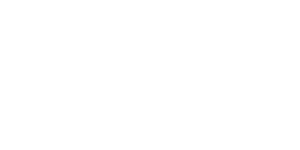

<IPython.core.display.Javascript object>


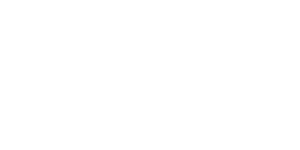

<IPython.core.display.Javascript object>


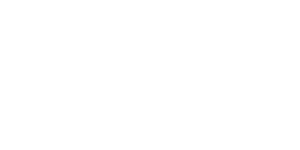

<IPython.core.display.Javascript object>


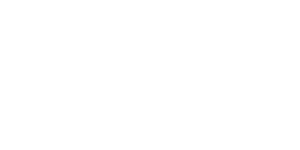

<IPython.core.display.Javascript object>


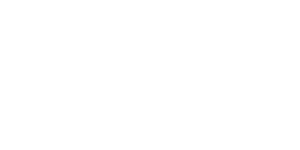

<IPython.core.display.Javascript object>


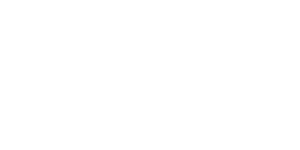

<IPython.core.display.Javascript object>


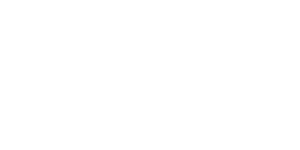

<IPython.core.display.Javascript object>


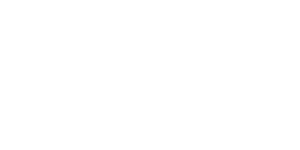

<IPython.core.display.Javascript object>


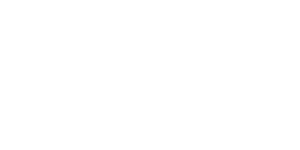

<IPython.core.display.Javascript object>


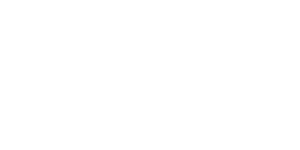

<IPython.core.display.Javascript object>


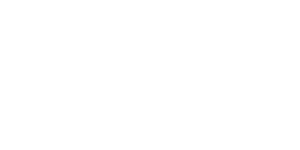

<IPython.core.display.Javascript object>


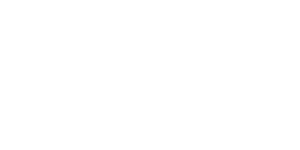

<IPython.core.display.Javascript object>


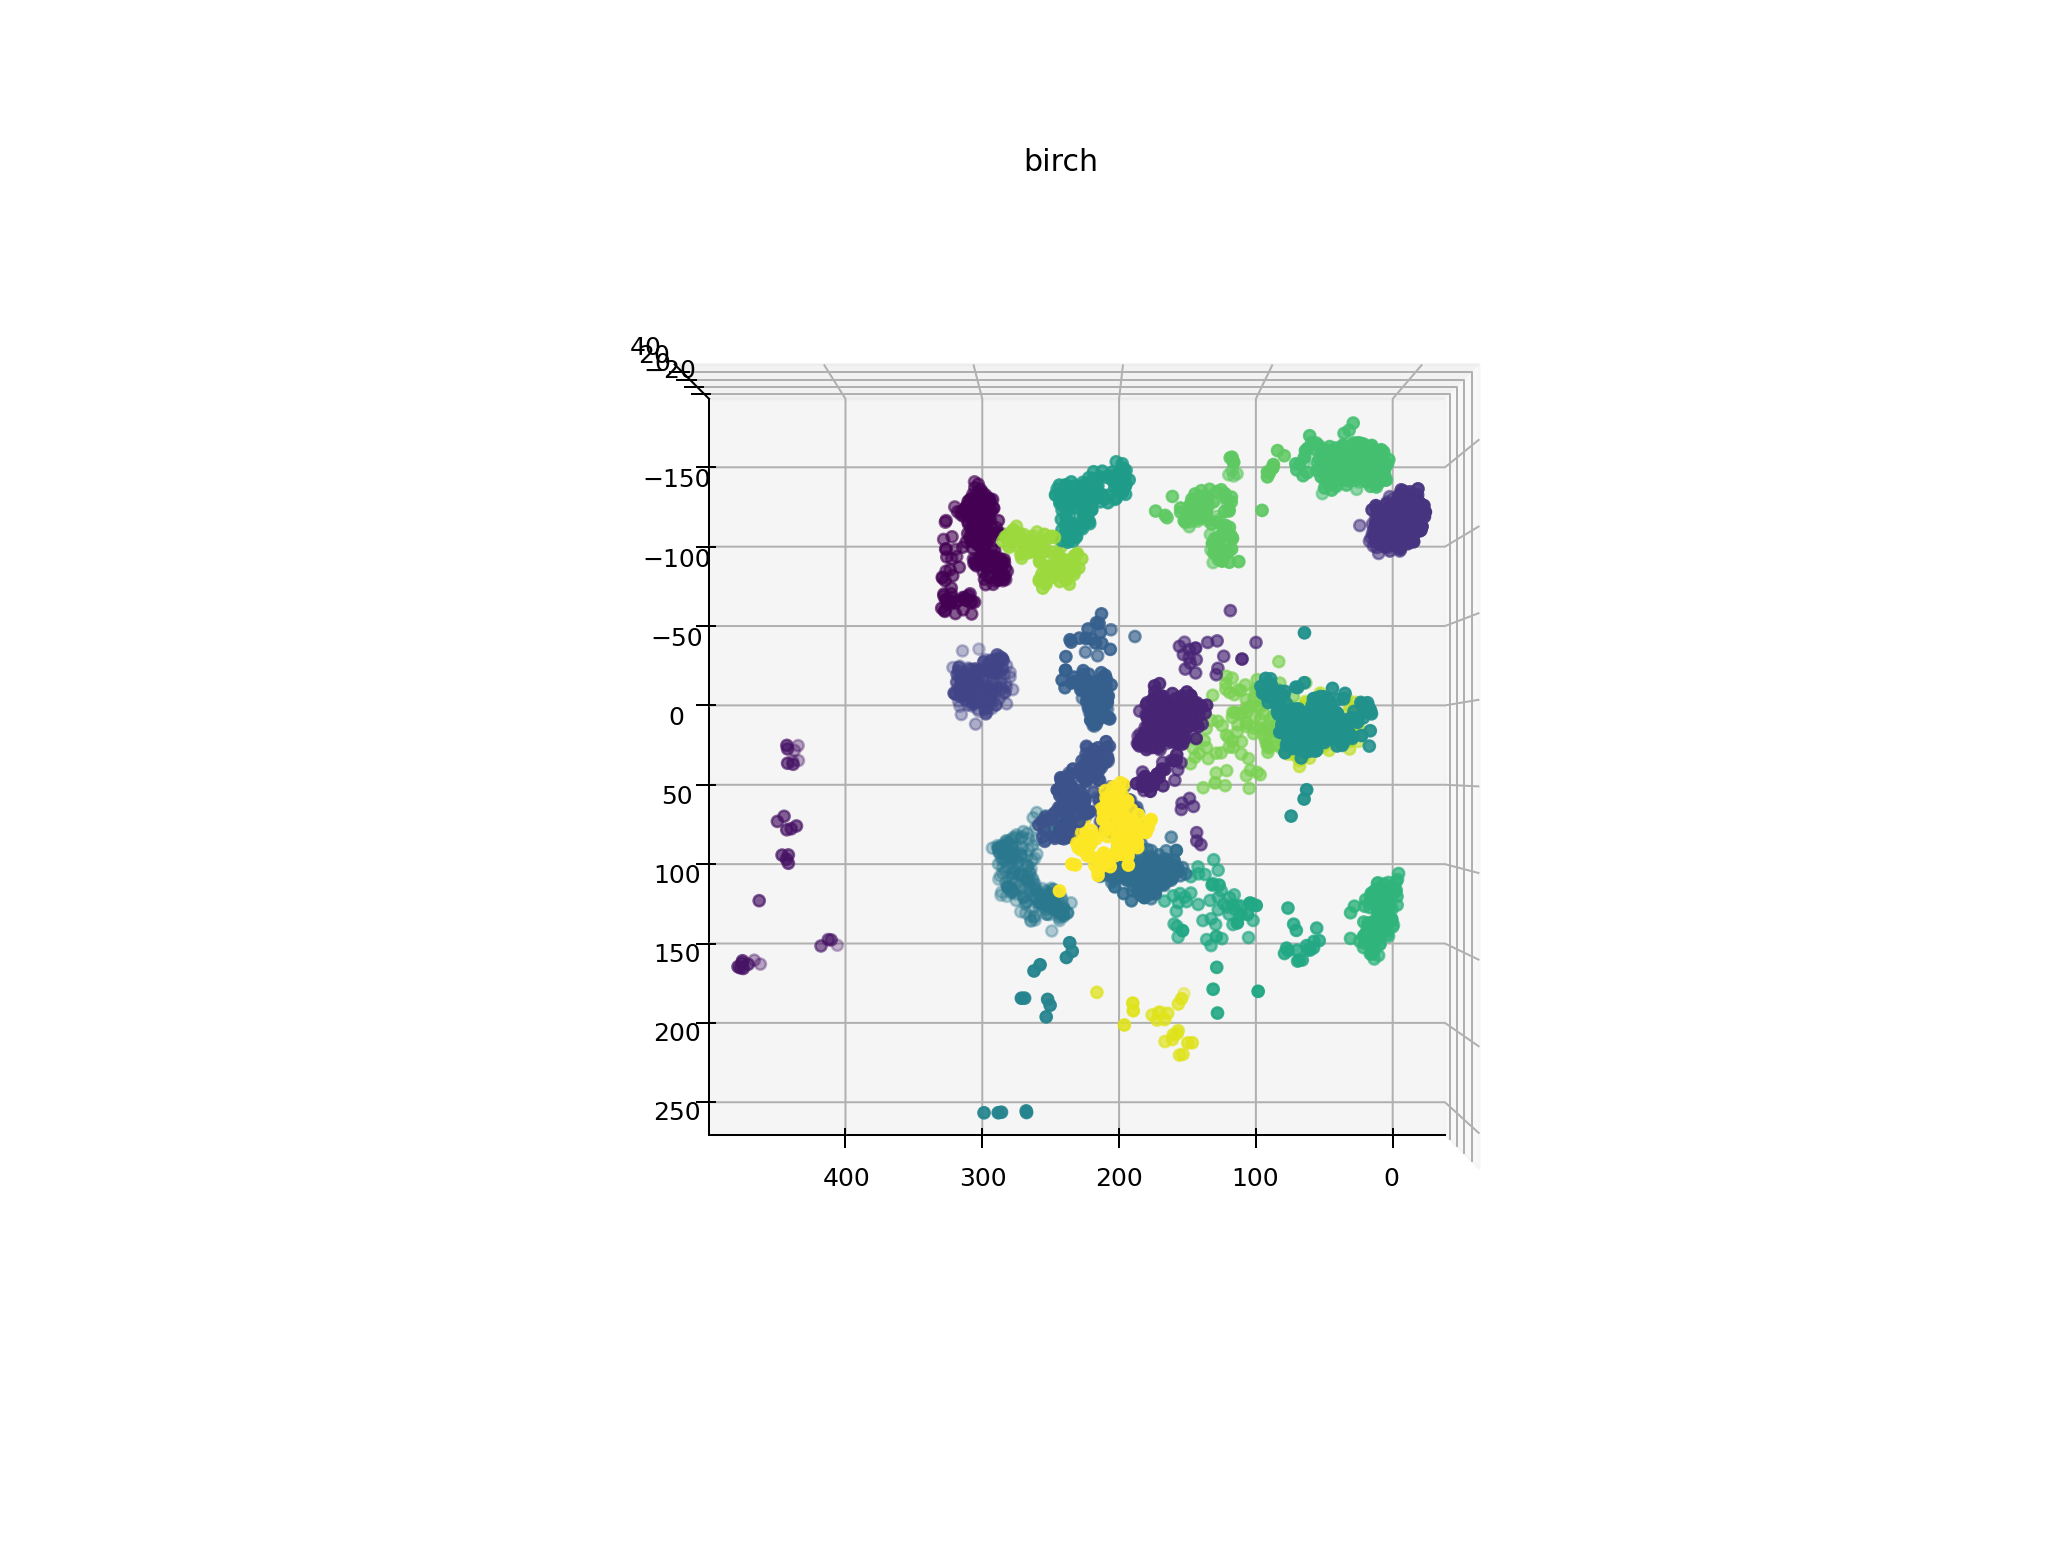

In [87]:
models = {'k_means': KMeans(n_clusters=21, random_state=21, init='k-means++'), 
          'agglomerative': AgglomerativeClustering(n_clusters=21, linkage='ward'), 
          'birch': Birch(n_clusters=21)}

for model_name, model in models.items():
    pipeline(model, model_name)